In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [54]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/project/chapter_10_utils.py')

In [55]:
!cp /content/gdrive/MyDrive/project/chapter_10_utils.py .

In [56]:
!cp /content/gdrive/MyDrive/project/credit_card_default.csv .

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6, 2.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Deep Learning in Finance

## Deep Learning for Tabular Data

1. Import the libraries:

In [7]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from chapter_10_utils import performance_evaluation_report, custom_set_seed
# set seed for reproducibility
custom_set_seed(42)

2. Load the dataset from a CSV file:

In [8]:
df= pd.read_csv('/content/gdrive/MyDrive/project/credit_card_default.csv')
df.head()

,Unnamed: 0,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,Unknown,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


3. Identify the dependent variable (target) and numerical/categorical features:

In [9]:
DEP_VAR = 'default_payment_next_month'

num_features = list(df.select_dtypes('number').columns)
num_features.remove(DEP_VAR)
cat_features = list(df.select_dtypes('object').columns)

preprocessing = [FillMissing, Categorify, Normalize]

4. Create a `TabularDataBunch` from the DataFrame:

In [10]:
data = (TabularList.from_df(df, 
                            cat_names=cat_features,
                            cont_names=num_features, 
                            procs=preprocessing)
                   .split_by_rand_pct(valid_pct=0.2, seed=42)
                   .label_from_df(cols=DEP_VAR)
                   .databunch())

We additionally inspect a few rows from the DataBunch:

In [11]:
data.show_batch(rows=5)

sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,Unnamed: 0,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,target
Female,High school,Married,Unknown,Unknown,Unknown,Payment delayed 2 months,Unknown,Unknown,False,0.5552,-1.0577,1.3579,-0.1903,-0.1902,-0.1594,-0.1689,-0.1677,-0.1783,-0.2410,-0.1077,-0.2882,-0.2380,-0.2445,-0.2382,0
Female,Graduate school,Single,Payment delayed 1 month,Payment delayed 3 months,Payment delayed 2 months,Unknown,Unknown,Payed duly,False,-1.0130,1.0234,0.2724,-0.5527,-0.5530,-0.6206,-0.6414,-0.6569,-0.6141,-0.3319,-0.2453,-0.2882,-0.2994,-0.1574,-0.2955,0
Female,High school,Married,Payed duly,Payed duly,Payed duly,Payed duly,Payed duly,Payed duly,False,1.3314,0.2526,1.5750,-0.6885,-0.6842,-0.6694,-0.6653,-0.6557,-0.6473,-0.3091,-0.2294,-0.2669,-0.2754,-0.2835,-0.2732,0
Female,University,Single,Payed duly,Payed duly,Payed duly,Payed duly,Payed duly,Payed duly,False,-0.0317,1.7942,0.9237,-0.6259,-0.6476,0.7235,-0.1447,-0.5773,-0.6269,-0.1562,3.7634,1.5708,0.0176,-0.2054,-0.2955,0
Female,High school,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,-0.1685,-0.2869,0.4895,0.7047,-0.6897,-0.6750,-0.6714,-0.6622,-0.6539,-0.3319,-0.2455,-0.2882,-0.2994,-0.3085,-0.2955,0


5. Define the `Learner` object:

In [12]:
learn = tabular_learner(data, layers=[1000,500],
                        ps=[0.001,0.01],
                        emb_drop=0.04,
                        metrics=[Recall(),
                                 FBeta(beta=1),
                                 FBeta(beta=5)])

6. Inspect the model's architecture:

In [13]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(11, 6)
    (5): Embedding(11, 6)
    (6): Embedding(11, 6)
    (7): Embedding(10, 6)
    (8): Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=2, bias=True)
  )
)

`Embedding(11, 6)` means that a categorical embedding was created with 11 input values and 6 output latent features.

7. Find the suggested learning rate:

epoch,train_loss,valid_loss,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 6.92E-03


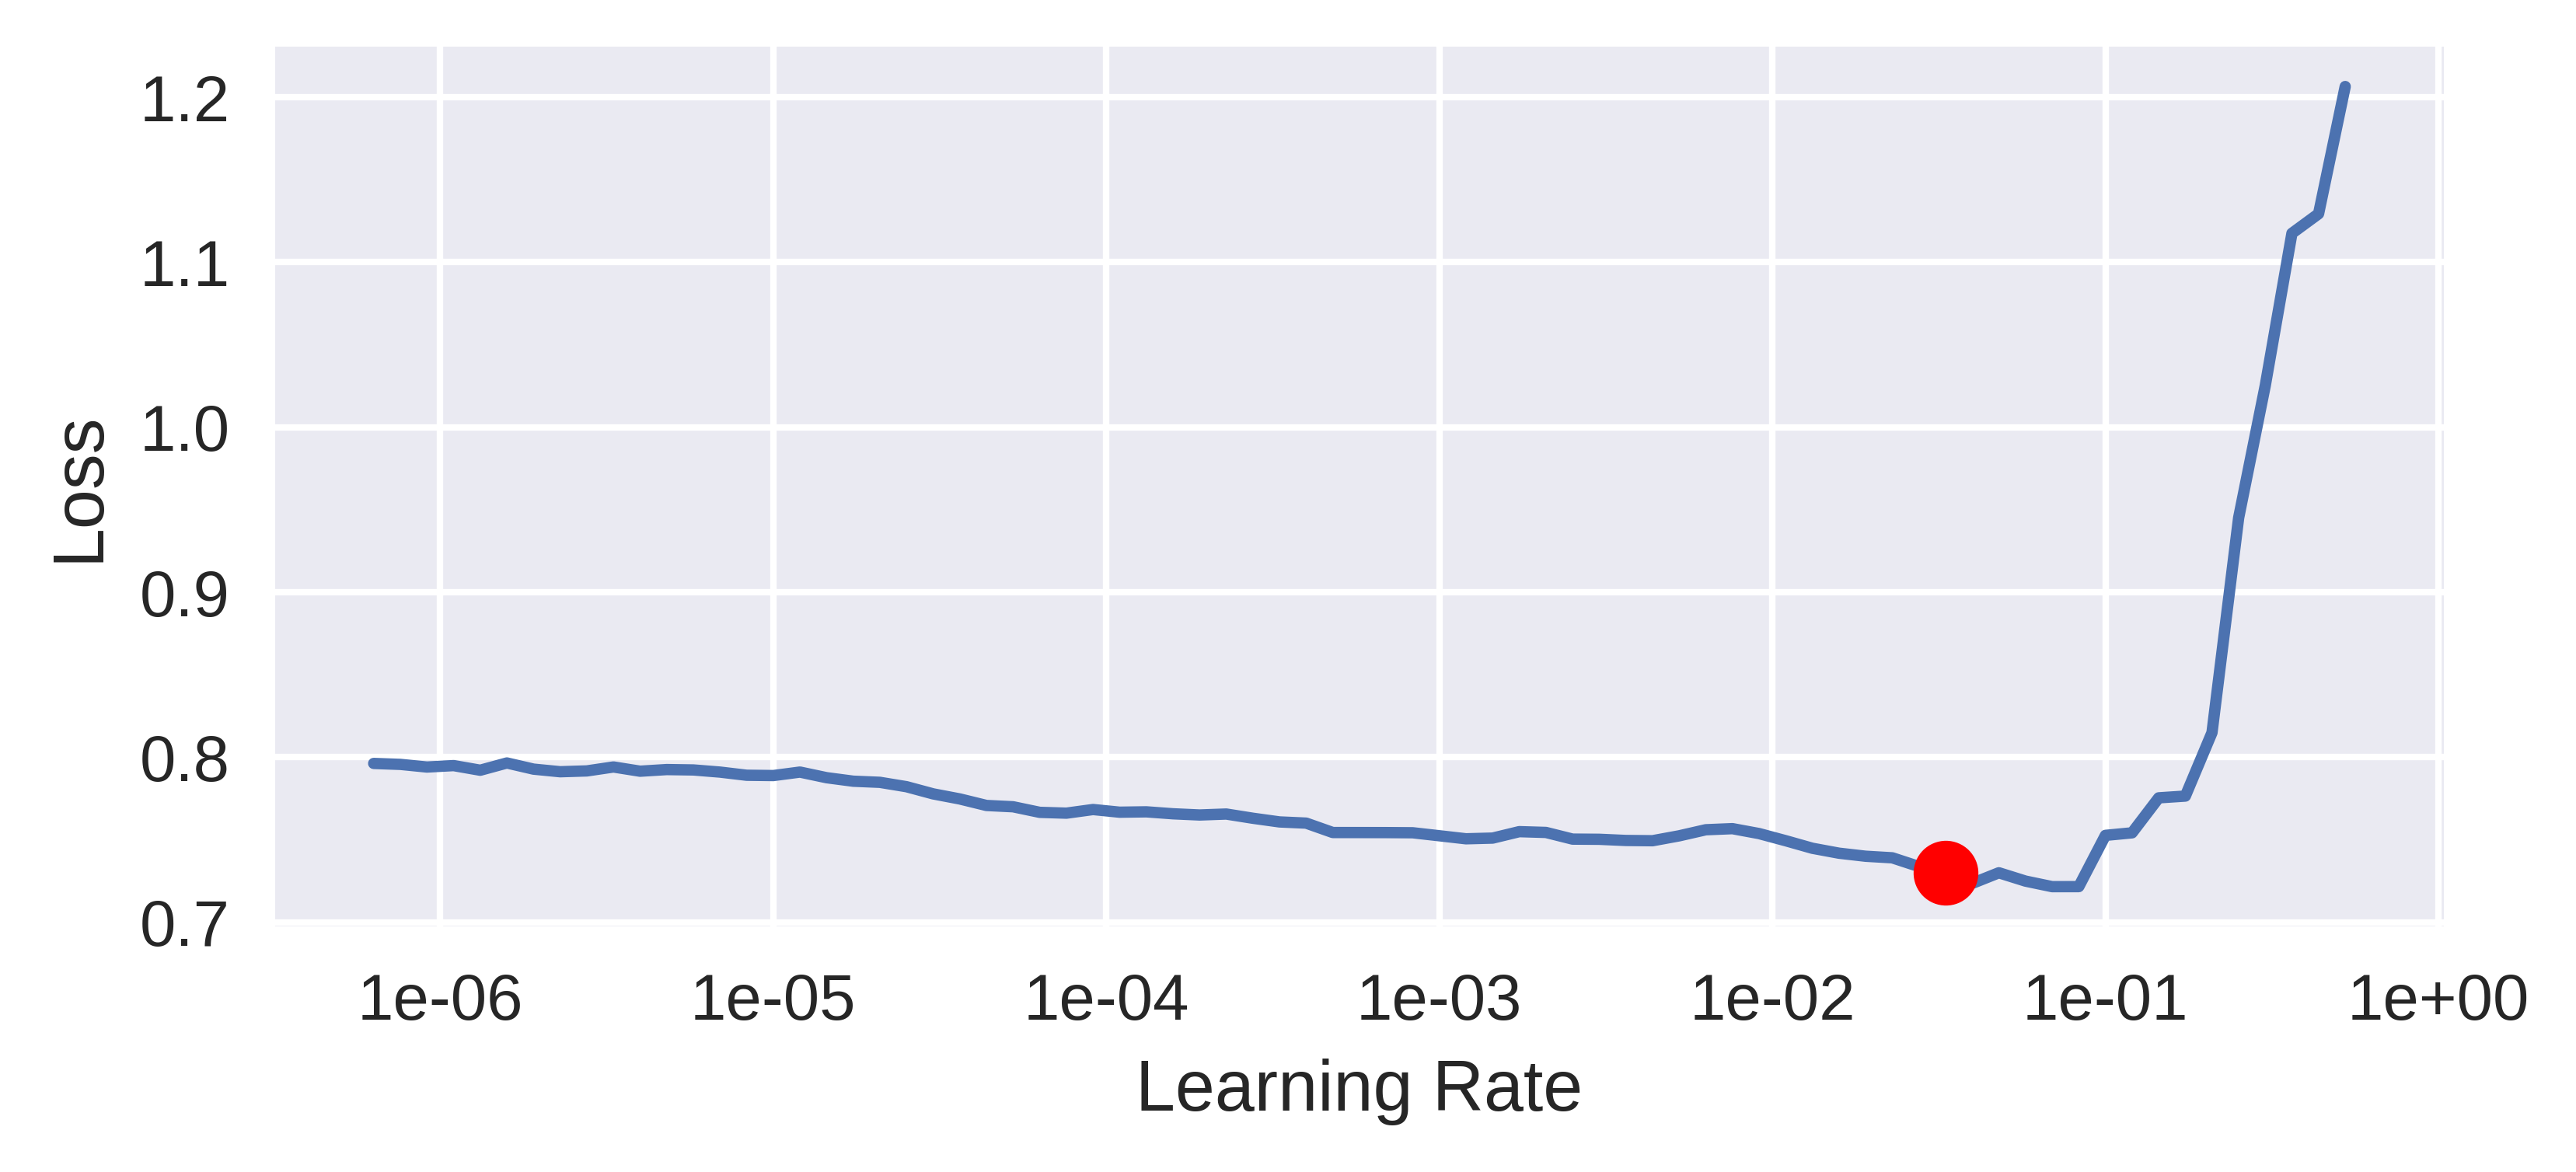

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

# plt.tight_layout()
plt.show()

8. Train the Neural Network:

In [15]:
learn.fit(epochs=25, lr=1e-6, wd=0.2)

epoch,train_loss,valid_loss,recall,f_beta,f_beta,time
0,0.697162,0.692102,0.661081,0.374622,0.624357,00:07
1,0.681680,0.673539,0.654989,0.395221,0.623466,00:07
2,0.679841,0.658293,0.613861,0.397632,0.589214,00:07
3,0.675215,0.645481,0.557502,0.394503,0.540329,00:07
4,0.668035,0.643984,0.578066,0.398007,0.558625,00:07
5,0.666403,0.639764,0.567403,0.402703,0.550097,00:07
6,0.667352,0.639375,0.536177,0.394398,0.521749,00:07
7,0.661138,0.635228,0.536938,0.398418,0.522952,00:07
8,0.656528,0.627081,0.517136,0.399060,0.505628,00:07
9,0.651797,0.626596,0.530845,0.406414,0.518631,00:07


9. Plot the losses:

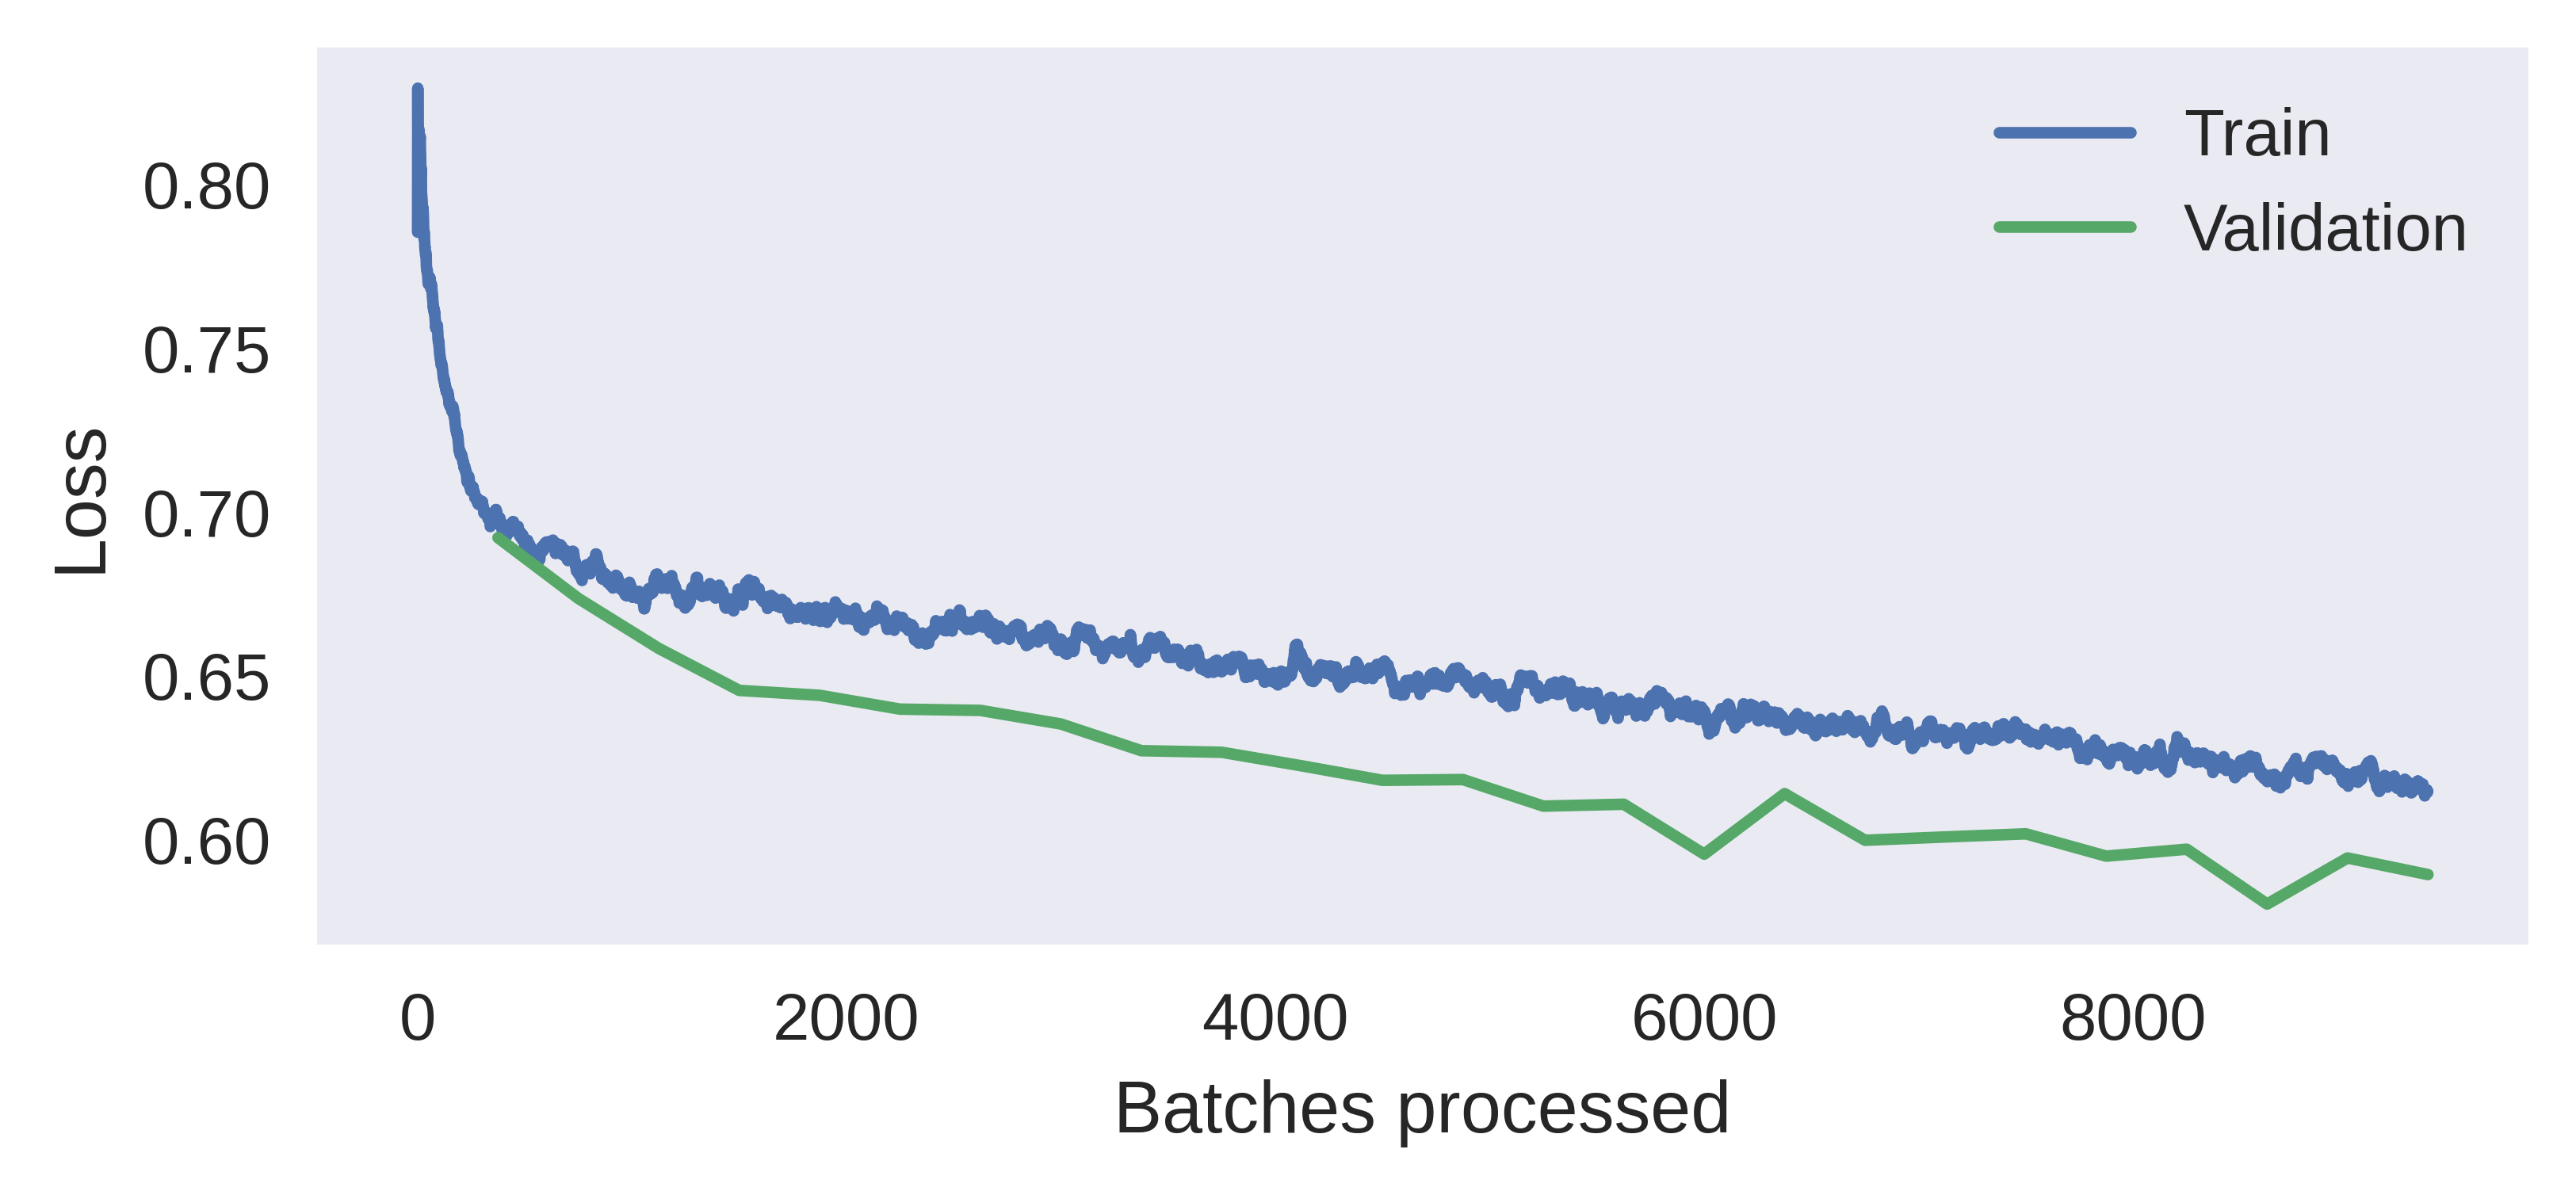

In [16]:
learn.recorder.plot_losses()

# plt.tight_layout()
plt.show()

10. Extract the predictions for the validation set:

In [17]:
preds_valid, _ = learn.get_preds(ds_type=DatasetType.Valid)
pred_valid = preds_valid.argmax(dim=-1)

11. Inspect the performance (confusion matrix) on the validation set:

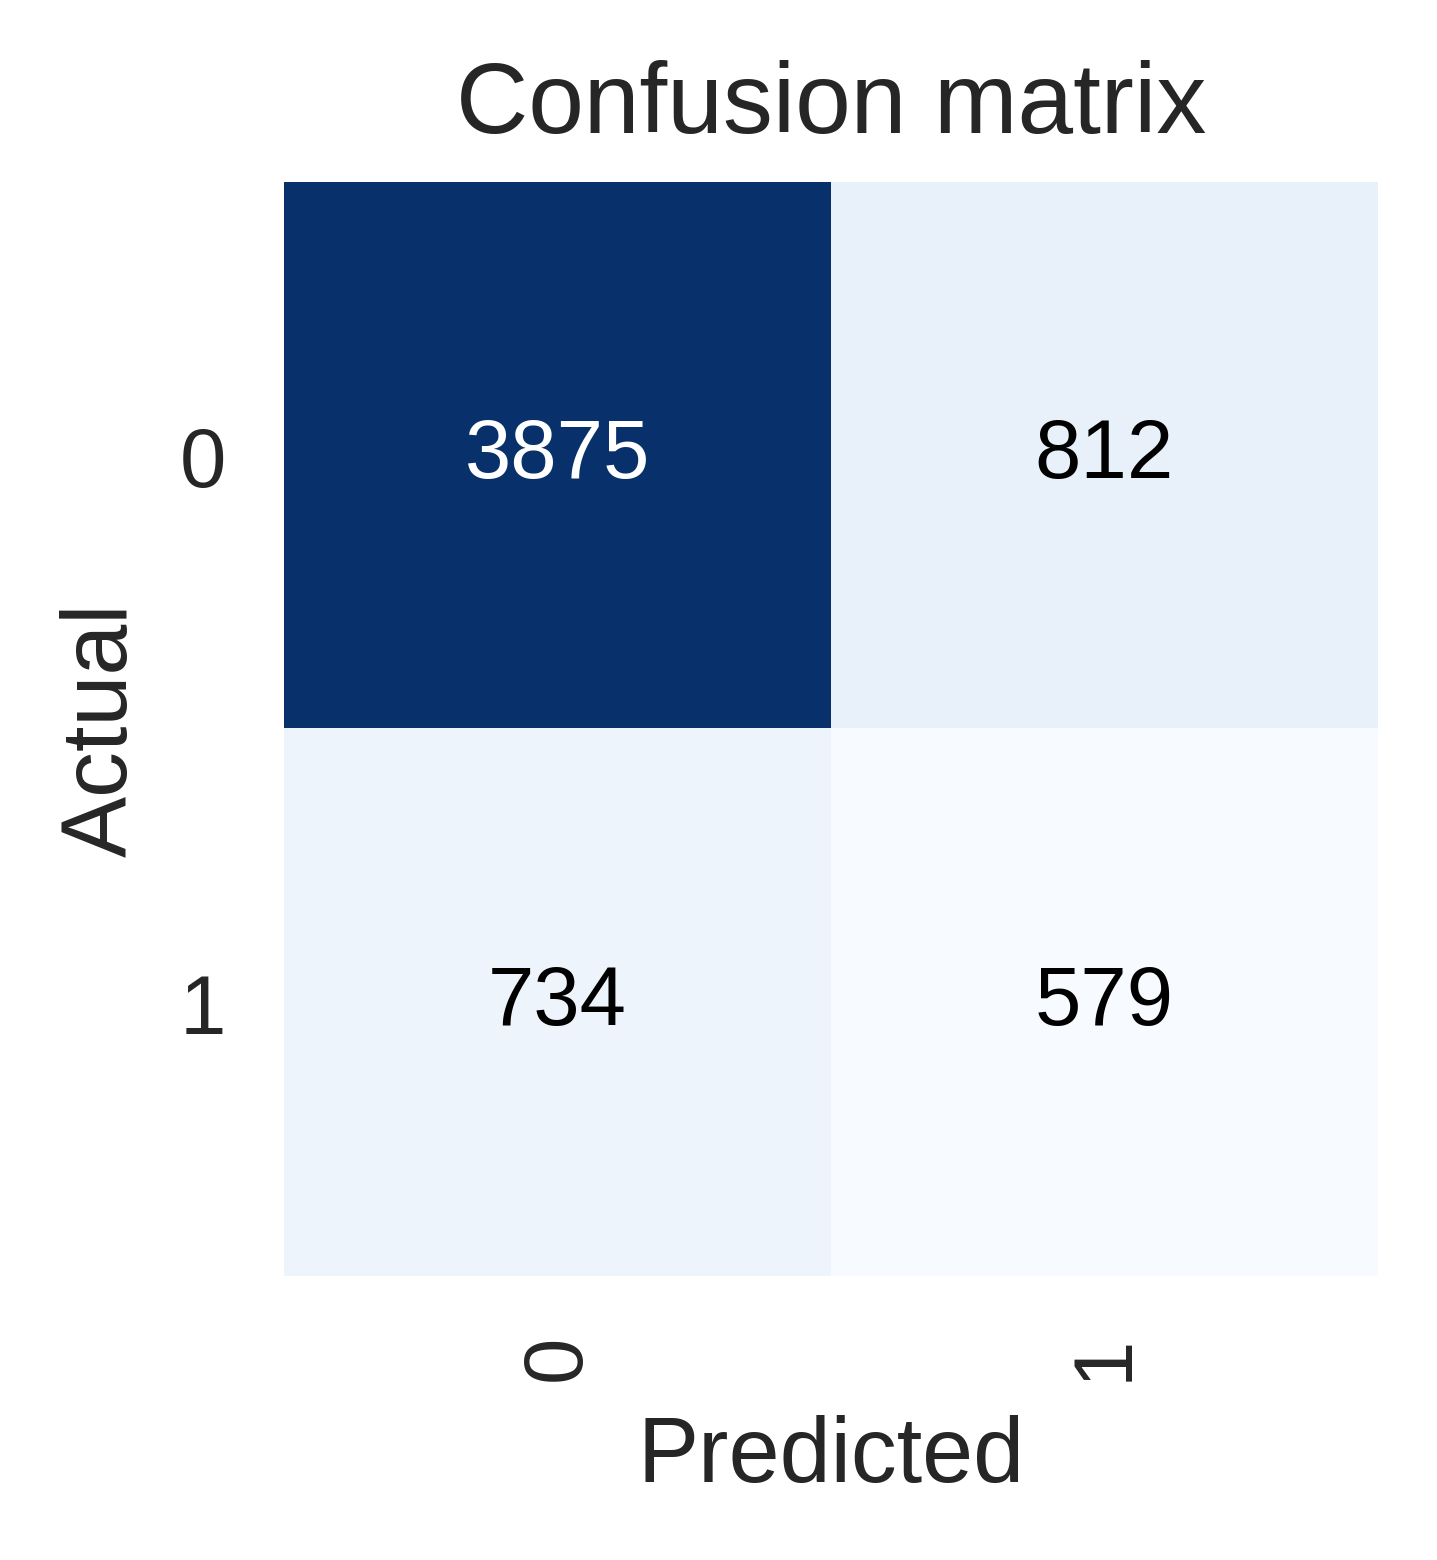

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# plt.tight_layout()
plt.show()

In [19]:
interp.plot_tab_top_losses(5)

,Prediction,Actual,Loss,Probability,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,Unnamed: 0,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr
0,1,0,2.00,0.14,Female,Others,Single,months,Unknown,Unknown,Unknown,Unknown,Unknown,False,0.6009,0.2526,1.6836,5.5090,5.5290,5.5841,5.9705,6.2493,1.0134,0.2937,0.1946,0.2752,0.4101,6.0197,8.6949
1,1,0,1.77,0.17,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,1.4410,0.5609,3.4205,6.7016,6.4812,6.1364,6.6364,6.6339,6.4176,0.8519,0.4706,4.1062,0.6309,0.7158,0.4567
2,0,1,1.70,0.18,Female,school,Married,Unknown,duly,duly,duly,duly,duly,False,1.2397,1.4088,-0.2704,0.4365,0.2766,-0.4162,-0.3909,-0.1552,-0.1295,3.7033,0.4965,0.7016,1.5956,1.6918,4.7714
3,0,1,1.63,0.20,Male,school,Single,duly,months,months,Unknown,Unknown,Unknown,False,0.6857,0.9463,-0.3789,-0.6429,-0.6370,-0.6211,2.1310,2.3418,2.4750,-0.3319,-0.2455,9.5492,0.1238,0.1140,0.1512
4,0,1,1.62,0.20,Male,school,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,-0.5320,-0.6723,-0.5960,0.3690,-0.6054,-0.5911,-0.5966,-0.6002,-0.5896,-0.2672,-0.2018,-0.2798,-0.2903,-0.3004,-0.2925


12. Inspect the performance evaluation metrics:

In [20]:
performance_evaluation_report(learn)

{'accuracy': 0.7423333333333333,
 'cohens_kappa': 0.2621249433428732,
 'f1_score': 0.4282544378698225,
 'pr_auc': 0.39612094545001103,
 'precision': 0.4162473040977714,
 'recall': 0.44097486671744096,
 'roc_auc': 0.7019157849546094,
 'specificity': 0.8267548538510775}

## Multilayer perceptrons for time series forecasting

1. Import the libraries:

In [23]:
pip install yfinance

     |████████████████████████████████| 6.3MB 9.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=f4dd7e0f61800904a962e7cc183fdce26647de2d992ea1a20770969193a97845
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [24]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, 
                              DataLoader, Subset)

from sklearn.metrics import mean_squared_error

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.9.0+cu102


2. Define parameters:

In [25]:
# data
TICKER = 'ANF'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
N_LAGS = 3

# neural network 
VALID_SIZE = 12
BATCH_SIZE = 5
N_EPOCHS = 1000

3. Download and prepare the data:

In [26]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('M').last()
prices = df['Adj Close'].values

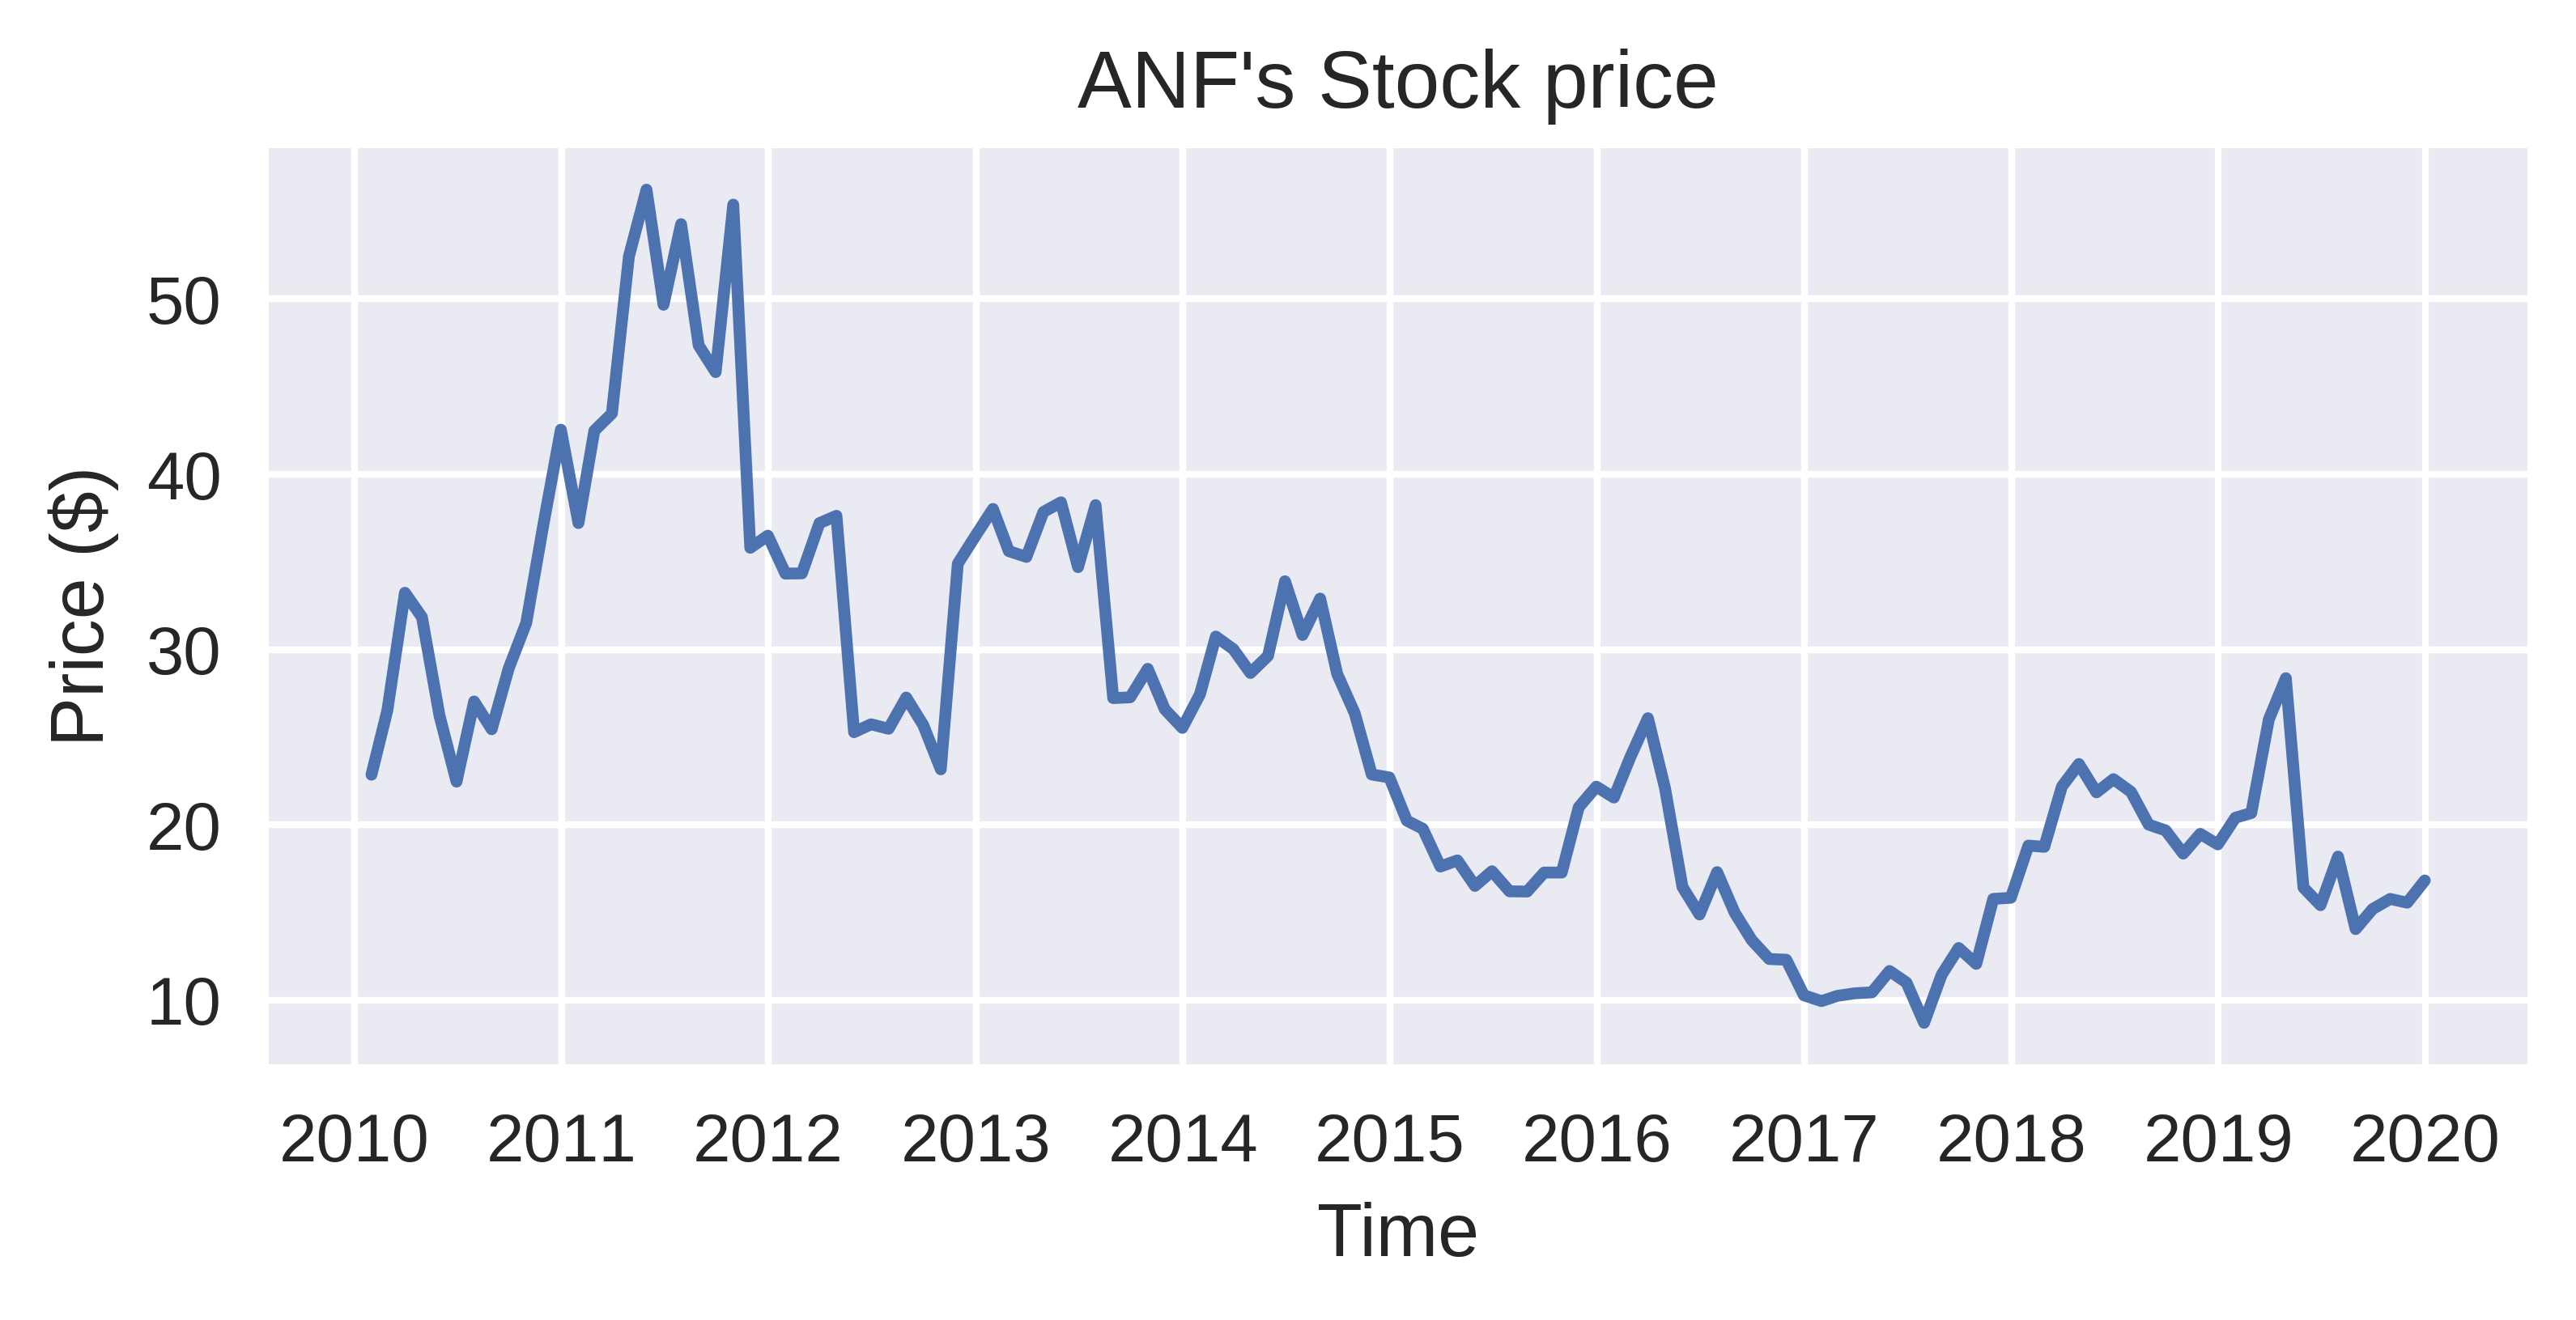

In [27]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Define a function for transforming time series into a dataset for the MLP:

In [32]:
def create_input_data(series, n_lags=1):
  '''
  Function for transforming time series into input acceptable by a multilayer perceptron.

  Parameters
  ----------
  series : np.array
  The time series to be transformed
  n_lags : int
  The number of lagged observations to consider as features

  Returns
  -------
  X : np.array
  Array of features
  y : np.array
  Array of target
  '''
  X, y = [], []

  for step in range(len(series) - n_lags):
    end_step = step + n_lags
    X.append(series[step:end_step])
    y.append(series[end_step])
  return np.array(X), np.array(y)

5. Transform the considered time series into input for the MLP:

In [33]:
X, y = create_input_data(prices, N_LAGS)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

6. Create training and validation sets:

In [34]:
valid_ind = len(X) - VALID_SIZE
dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Inspect the observations from the first batch:

In [35]:
next(iter(train_loader))[0]

tensor([[22.8548, 26.5230, 33.2375],
        [26.5230, 33.2375, 31.8466],
        [33.2375, 31.8466, 26.2224],
        [31.8466, 26.2224, 22.4606],
        [26.2224, 22.4606, 27.0347]])

In [36]:
next(iter(train_loader))[1]

tensor([[31.8466],
        [26.2224],
        [22.4606],
        [27.0347],
        [25.4489]])

Check the size of the datasets:

In [37]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 105 | validation: 12


7. Use naive forecast as a benchmark and evaluate the performance:

In [38]:
naive_pred = prices[len(prices) - VALID_SIZE - 1:-1]
y_valid = prices[len(prices) - VALID_SIZE:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 17.37, RMSE: 4.17


In [39]:
# BONUS: Testing Linear Regression

# from sklearn.linear_model import LinearRegression

# X_train = X[:valid_ind, ]
# y_train = y[:valid_ind]

# X_valid = X[valid_ind:, ]
# y_valid = y[valid_ind:]

# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)

# y_pred = lin_reg.predict(X_valid)
# lr_mse = mean_squared_error(y_valid, y_pred)
# lr_rmse = np.sqrt(lr_mse)
# print(f"Linear Regression's forecast - MSE: {lr_mse:.2f}, RMSE: {lr_rmse:.2f}")
# print(f"Linear Regression's coefficients: {lin_reg.coef_}")

# fig, ax = plt.subplots()

# ax.plot(y_valid, color='blue', label='Actual')
# ax.plot(y_pred, color='red', label='Prediction')

# ax.set(title="Linear Regression's Forecasts", 
#        xlabel='Time', 
#        ylabel='Price ($)')
# ax.legend();

8. Define the network's architecture:

In [40]:
class MLP(nn.Module):

  def __init__(self, input_size):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_size, 8)
    self.linear2 = nn.Linear(8, 4)
    self.linear3 = nn.Linear(4, 1)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    return x

9. Instantiate the model, the loss function and the optimizer:

In [41]:
# set seed for reproducibility
torch.manual_seed(42)

model = MLP(N_LAGS).to(device) 
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
model

MLP(
  (linear1): Linear(in_features=3, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

10. Train the network:

In [48]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():

        model.eval()

        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')

<0> - Train. loss: 141.19 	 Valid. loss: 16.42
<50> - Train. loss: 103.49 	 Valid. loss: 16.92
<100> - Train. loss: 120.71 	 Valid. loss: 17.70
<150> - Train. loss: 80.26 	 Valid. loss: 16.51
<200> - Train. loss: 65.40 	 Valid. loss: 16.88
<250> - Train. loss: 93.23 	 Valid. loss: 16.09
<300> - Train. loss: 77.71 	 Valid. loss: 16.46
<350> - Train. loss: 63.46 	 Valid. loss: 16.19
<400> - Train. loss: 70.57 	 Valid. loss: 15.91
<450> - Train. loss: 98.78 	 Valid. loss: 15.86
<500> - Train. loss: 65.58 	 Valid. loss: 16.32
<550> - Train. loss: 93.16 	 Valid. loss: 15.71
<600> - Train. loss: 102.68 	 Valid. loss: 16.58
<650> - Train. loss: 81.08 	 Valid. loss: 15.69
<700> - Train. loss: 71.73 	 Valid. loss: 15.45
<750> - Train. loss: 68.59 	 Valid. loss: 16.10
<800> - Train. loss: 84.17 	 Valid. loss: 15.11
<850> - Train. loss: 71.37 	 Valid. loss: 15.54
<900> - Train. loss: 58.58 	 Valid. loss: 15.65
<950> - Train. loss: 68.49 	 Valid. loss: 14.96
Lowest loss recorded in epoch: 998


11. Plot the losses over epochs:

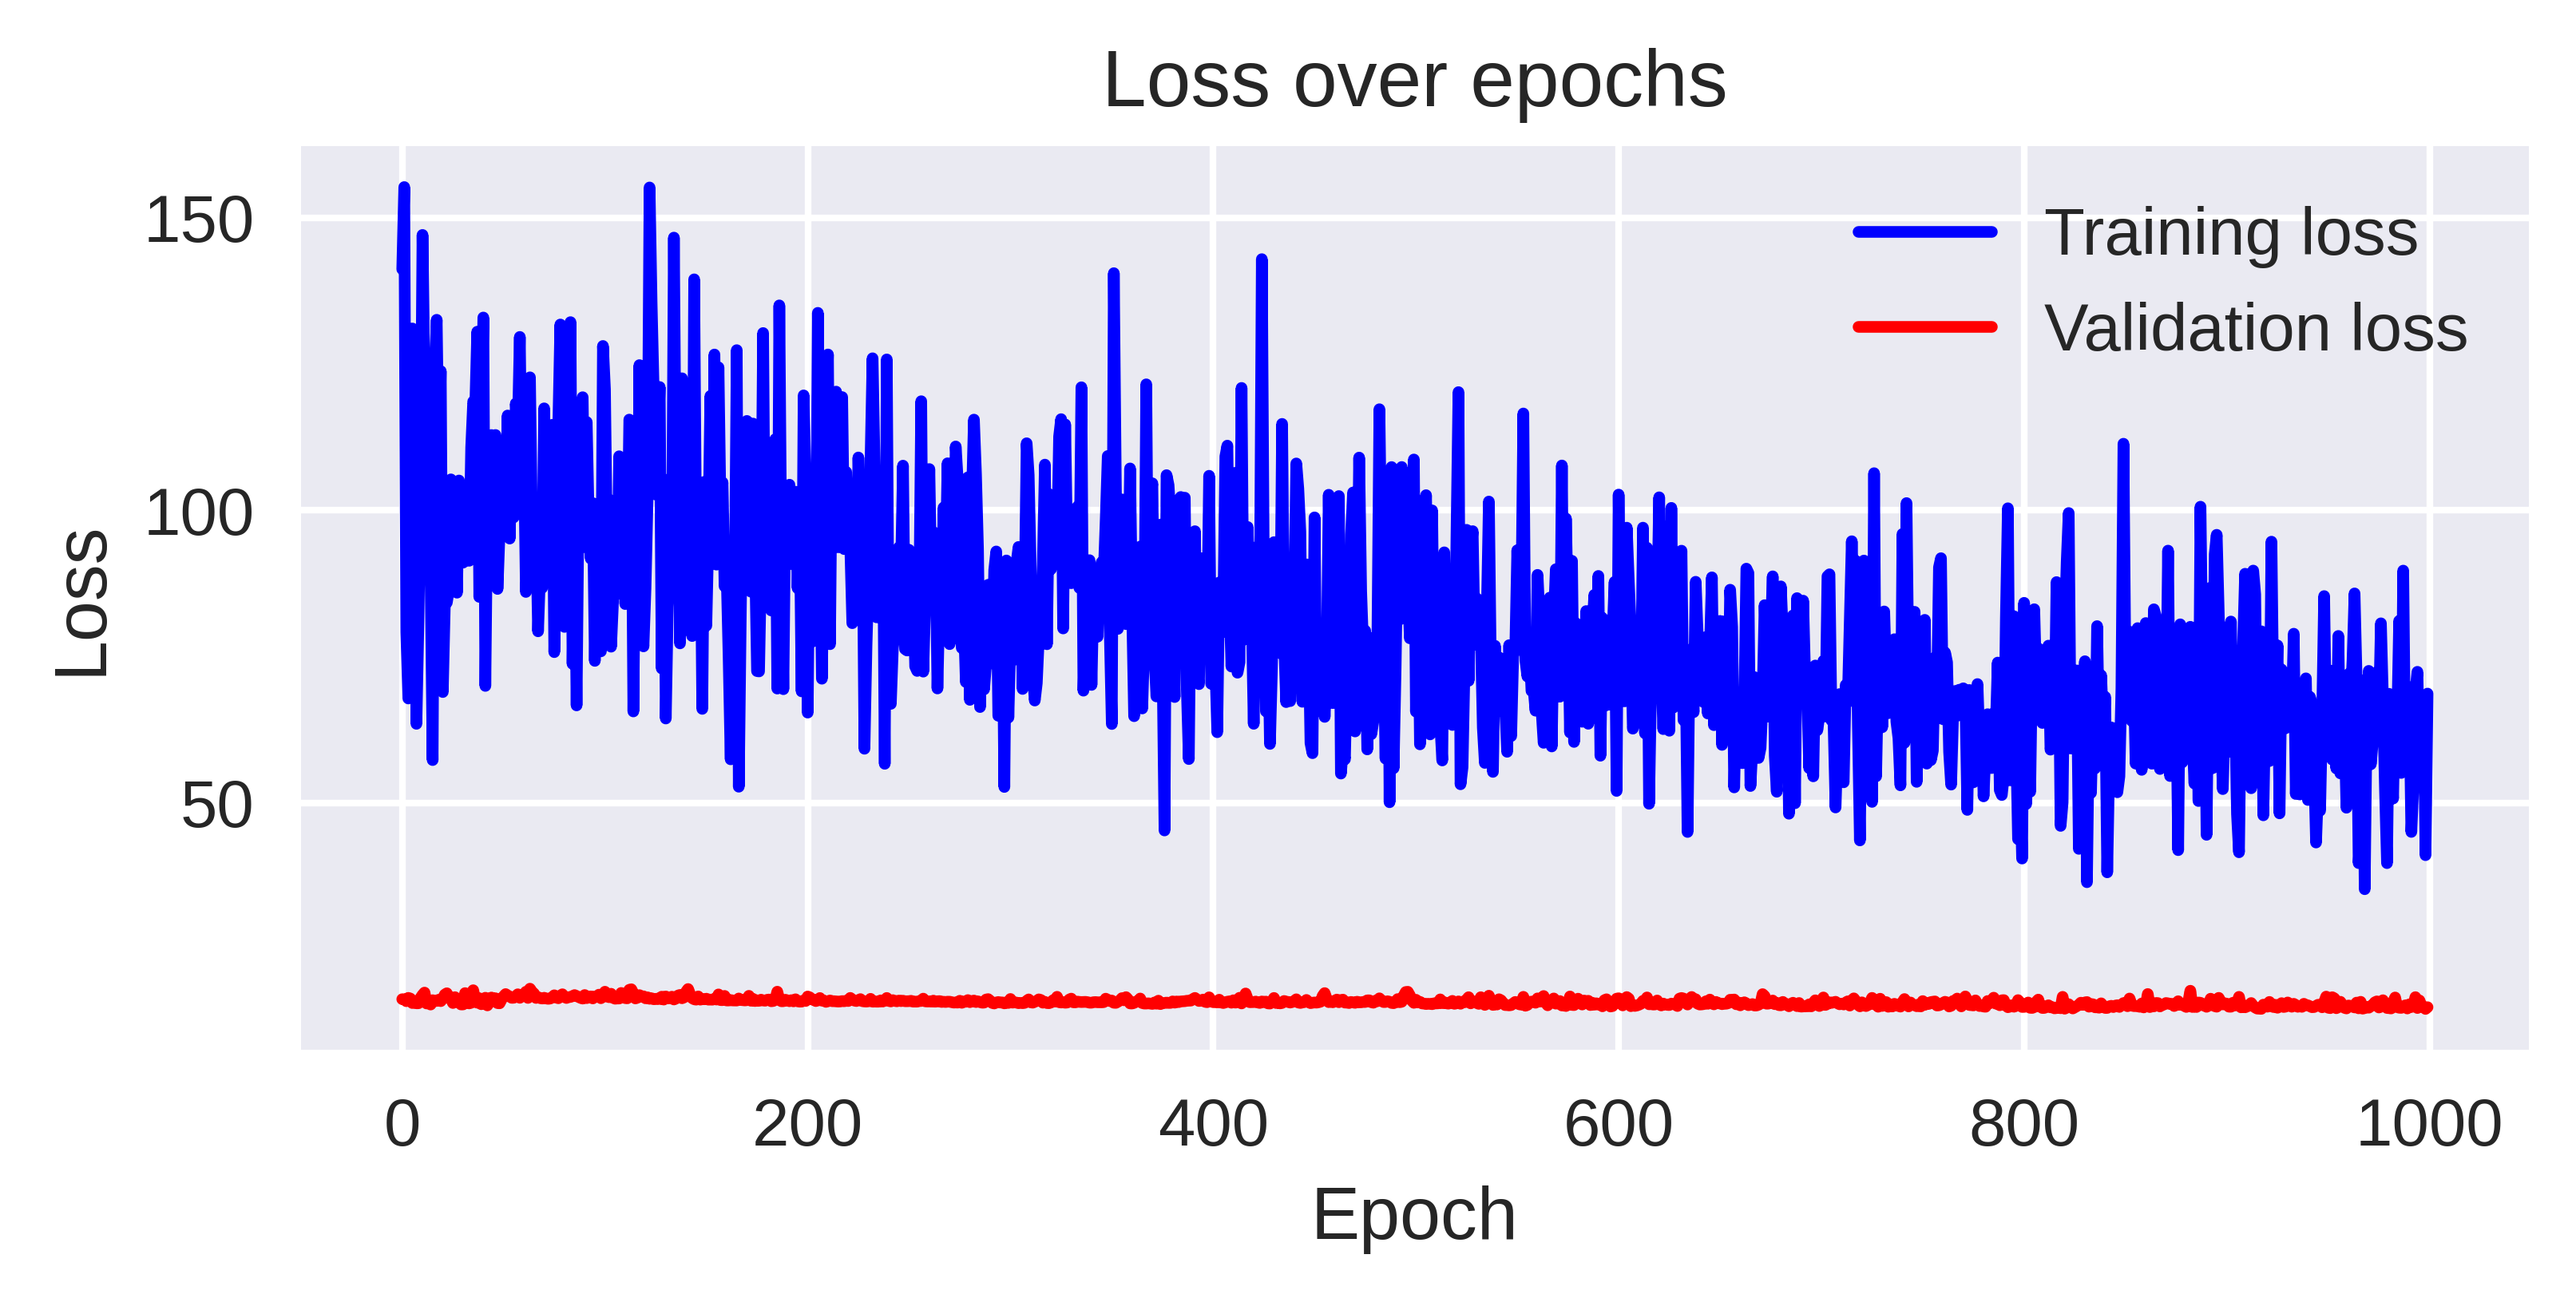

In [49]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title='Loss over epochs', 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
plt.show()

12. Load the best model (with the lowest validation loss):

In [50]:
state_dict = torch.load('mlp_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

13. Obtain the predictions:

In [51]:
y_pred, y_valid= [], []

with torch.no_grad():

    model.eval()
    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)    
        y_pred.append(model(x_val))
        y_valid.append(y_val)

y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

14. Evaluate the predictions:

MLP's forecast - MSE: 14.76, RMSE: 3.84


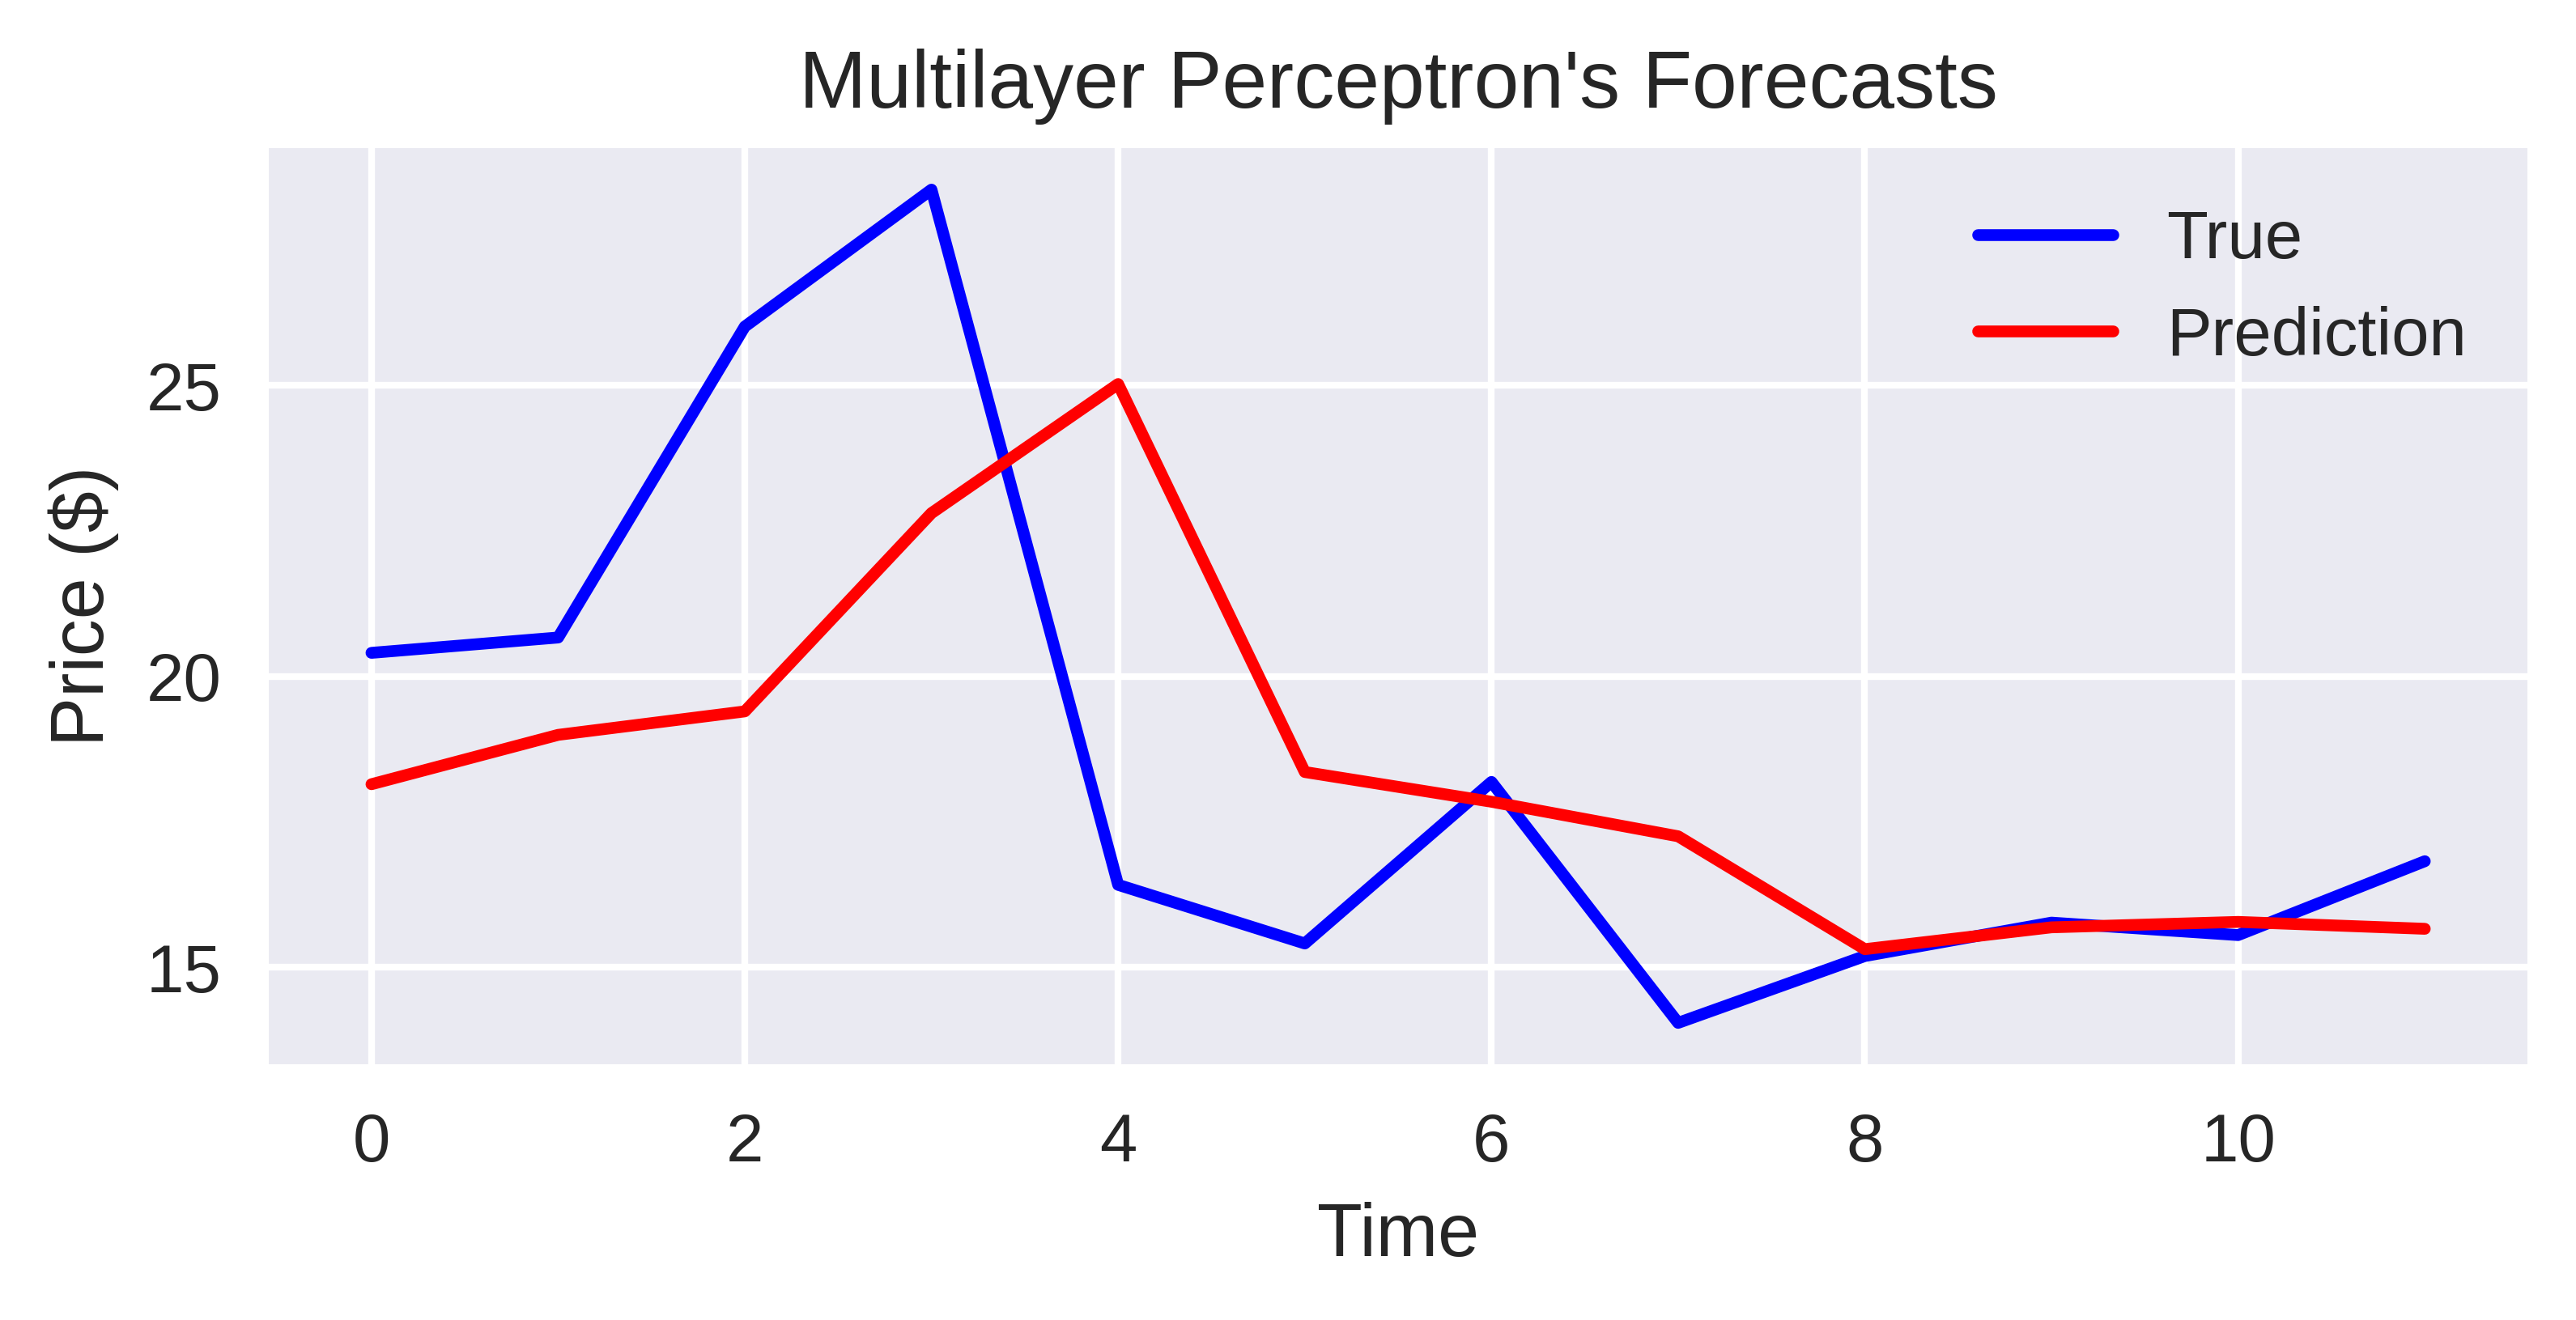

In [52]:
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print(f"MLP's forecast - MSE: {mlp_mse:.2f}, RMSE: {mlp_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label= 'True')
ax.plot(y_pred, color='red', label='Prediction')

ax.set(title="Multilayer Perceptron's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()

## Convolutional neural networks for time series forecasting

1. Import the libraries:

In [57]:
import yfinance as yf
import numpy as np
import os
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from chapter_10_utils import create_input_data, custom_set_seed
from sklearn.metrics import mean_squared_error
print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.9.0+cu102


2. Define the parameters:

In [70]:
# data
TICKER = 'INTC'
START_DATE = '2015-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 5
N_EPOCHS = 2000

3. Download and prepare the data:

In [71]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values

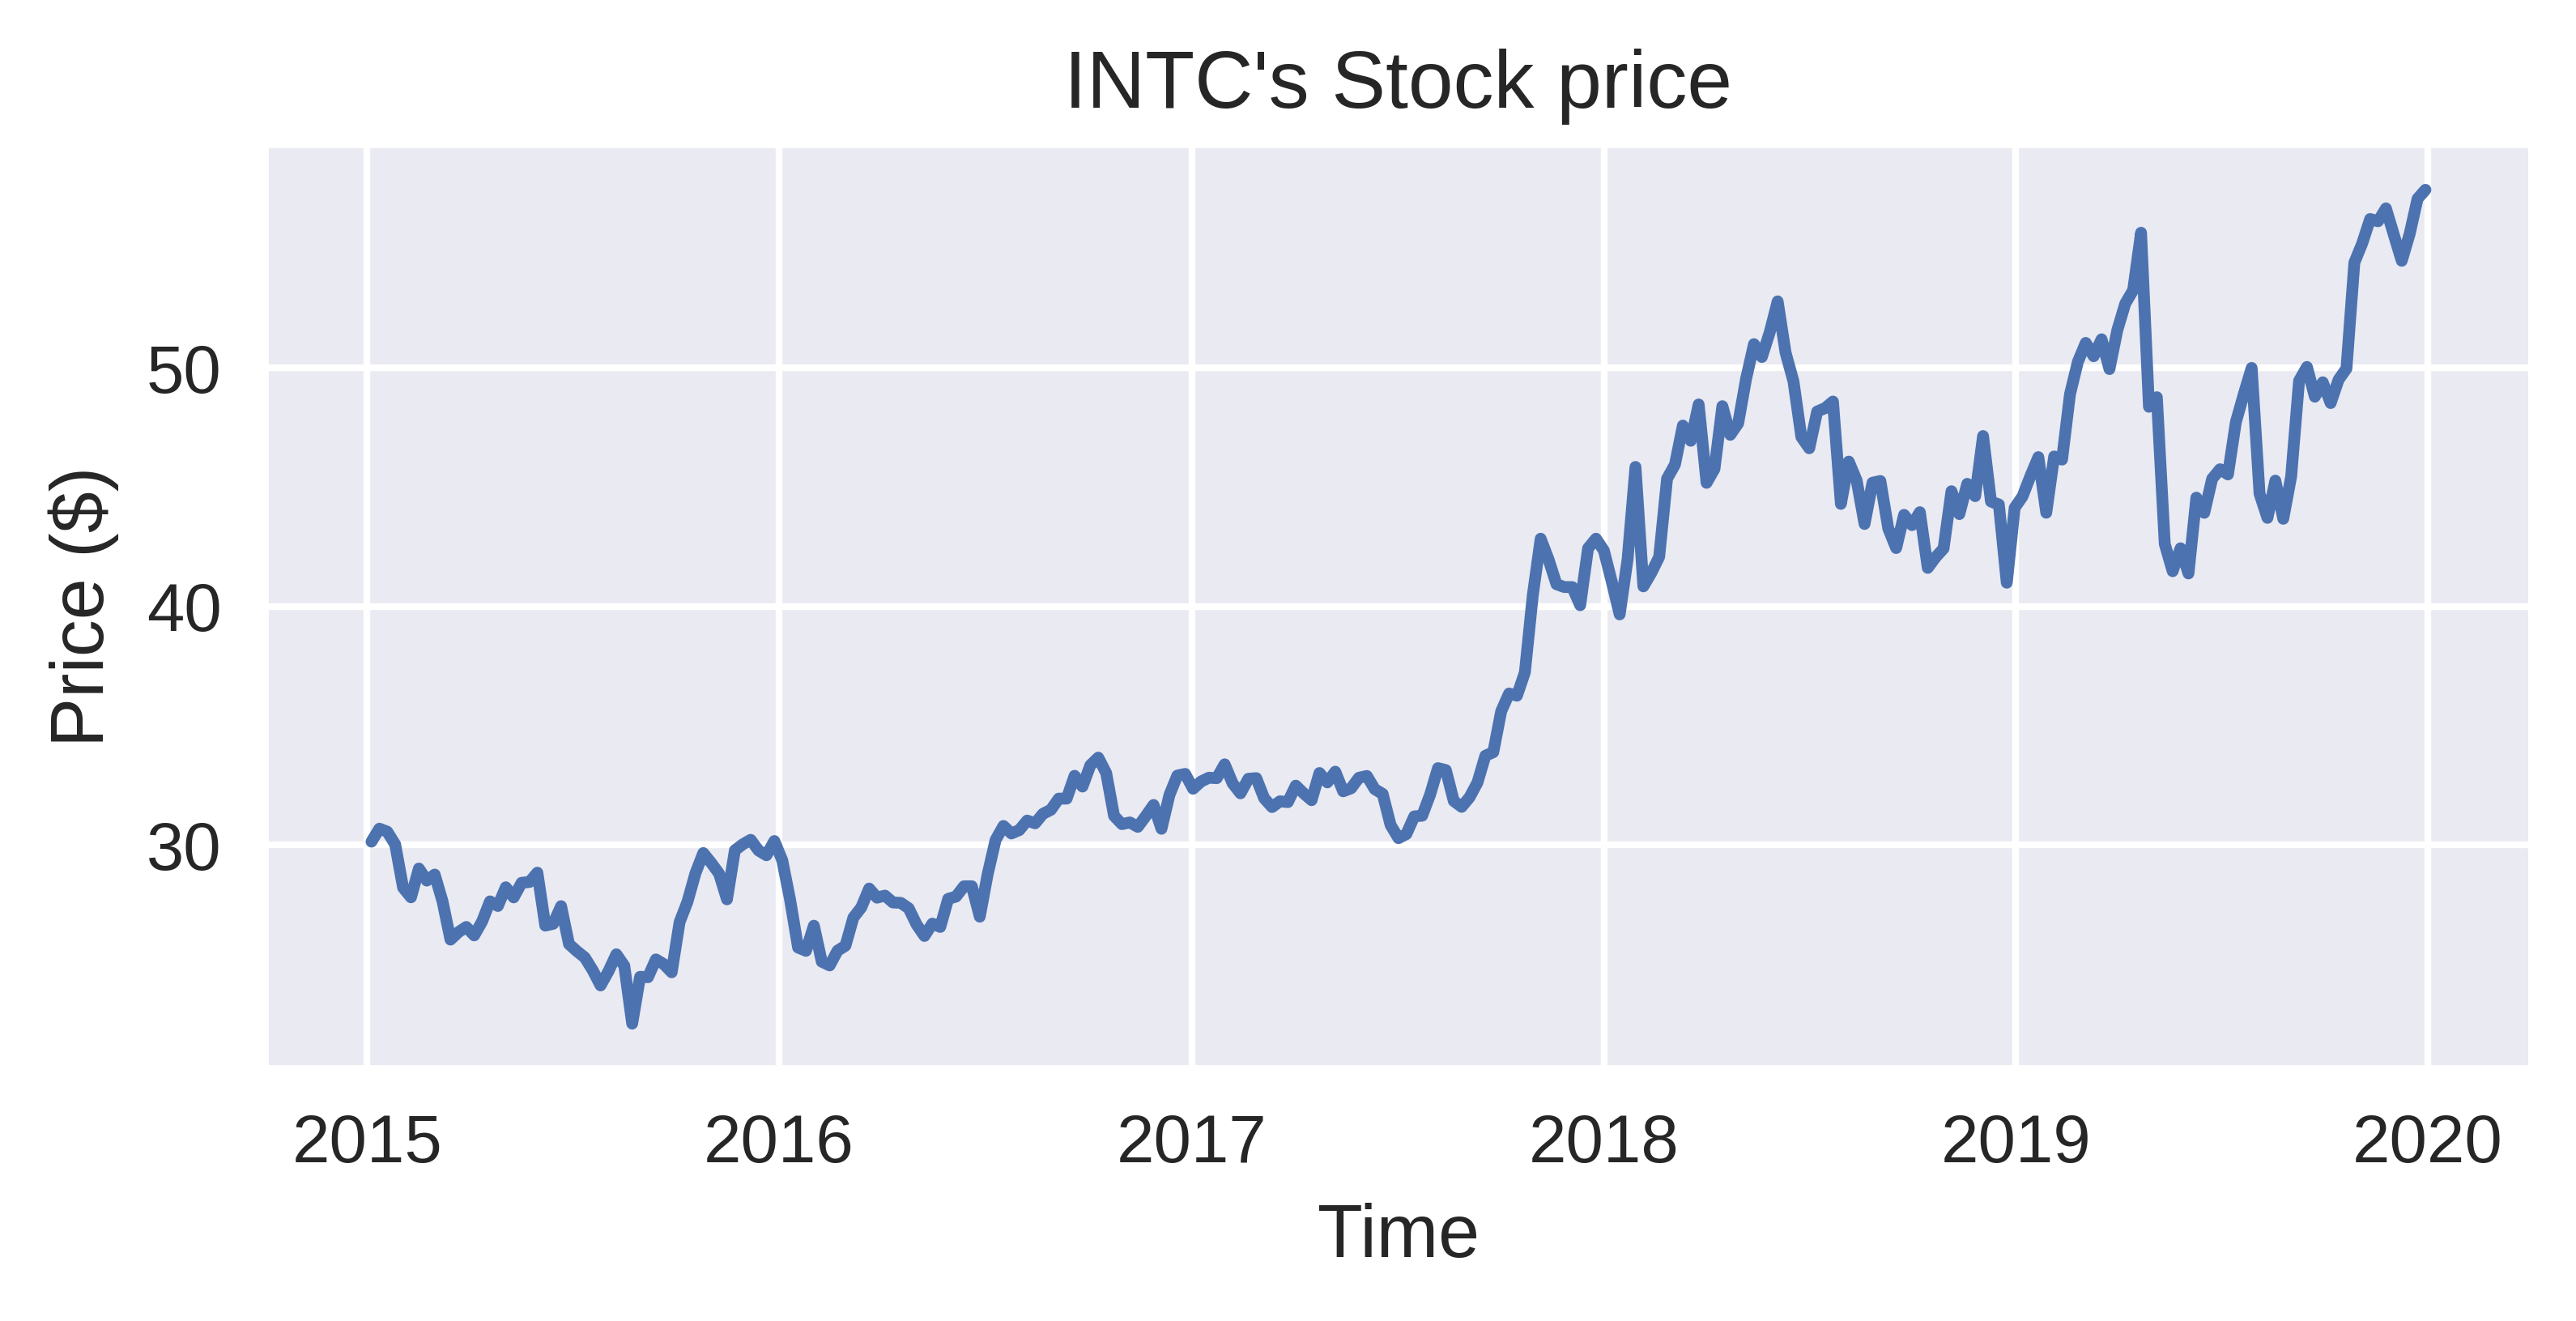

In [72]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Transform the time series into input for the CNN:

In [73]:
X, y = create_input_data(prices, N_LAGS)

5. Obtain the naïve forecast:

In [74]:
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 3.43, RMSE: 1.85


6. Prepare the `DataLoader` objects:

In [75]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Check the size of the datasets:

In [76]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 222 | validation: 27


7. Define the CNN's architecture:

In [77]:
class Flatten(nn.Module):
  def forward(self, x):
      return x.view(x.size()[0], -1)

model = nn.Sequential(OrderedDict([
    ('conv_1', nn.Conv1d(1, 32, 3, padding=1)),
    ('max_pool_1', nn.MaxPool1d(2)),
    ('relu_1', nn.ReLU()),
    ('flatten', Flatten()),
    ('fc_1', nn.Linear(192, 50)),
    ('relu_2', nn.ReLU()),
    ('dropout_1', nn.Dropout(0.4)),
    ('fc_2', nn.Linear(50, 1))
]))

print(model)

Sequential(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (flatten): Flatten()
  (fc_1): Linear(in_features=192, out_features=50, bias=True)
  (relu_2): ReLU()
  (dropout_1): Dropout(p=0.4, inplace=False)
  (fc_2): Linear(in_features=50, out_features=1, bias=True)
)


8. Instantiate the model, the loss function and the optimizer:

In [78]:
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

9. Train the network:

In [79]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        x_batch = x_batch.view(x_batch.shape[0], 1, N_LAGS)
        y_batch = y_batch.to(device)
        y_batch = y_batch.view(y_batch.shape[0], 1, 1)
        y_hat = model(x_batch).view(y_batch.shape[0], 1, 1)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
            y_val = y_val.to(device)
            y_val = y_val.view(y_val.shape[0], 1, 1)
            y_hat = model(x_val).view(y_val.shape[0], 1, 1)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
           best_epoch = epoch
           torch.save(model.state_dict(), './cnn_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.6f} \t Valid. loss: {epoch_loss_valid:.6f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


<0> - Train. loss: 10.321359 	 Valid. loss: 2.785670
<50> - Train. loss: 6.766999 	 Valid. loss: 6.202224
<100> - Train. loss: 6.854976 	 Valid. loss: 2.880346
<150> - Train. loss: 6.780445 	 Valid. loss: 1.943818
<200> - Train. loss: 5.992423 	 Valid. loss: 4.313991
<250> - Train. loss: 6.339961 	 Valid. loss: 1.702667
<300> - Train. loss: 6.178274 	 Valid. loss: 2.266017
<350> - Train. loss: 5.864429 	 Valid. loss: 2.006002
<400> - Train. loss: 5.890781 	 Valid. loss: 3.161372
<450> - Train. loss: 5.914538 	 Valid. loss: 1.989473
<500> - Train. loss: 5.451180 	 Valid. loss: 2.858346
<550> - Train. loss: 5.842583 	 Valid. loss: 2.255348
<600> - Train. loss: 5.416572 	 Valid. loss: 1.713428
<650> - Train. loss: 5.471490 	 Valid. loss: 2.194397
<700> - Train. loss: 5.293638 	 Valid. loss: 2.709534
<750> - Train. loss: 4.824833 	 Valid. loss: 1.804923
<800> - Train. loss: 4.779461 	 Valid. loss: 2.247493
<850> - Train. loss: 4.668743 	 Valid. loss: 2.068278
<900> - Train. loss: 4.151012 

10. Plot the losses over epochs:

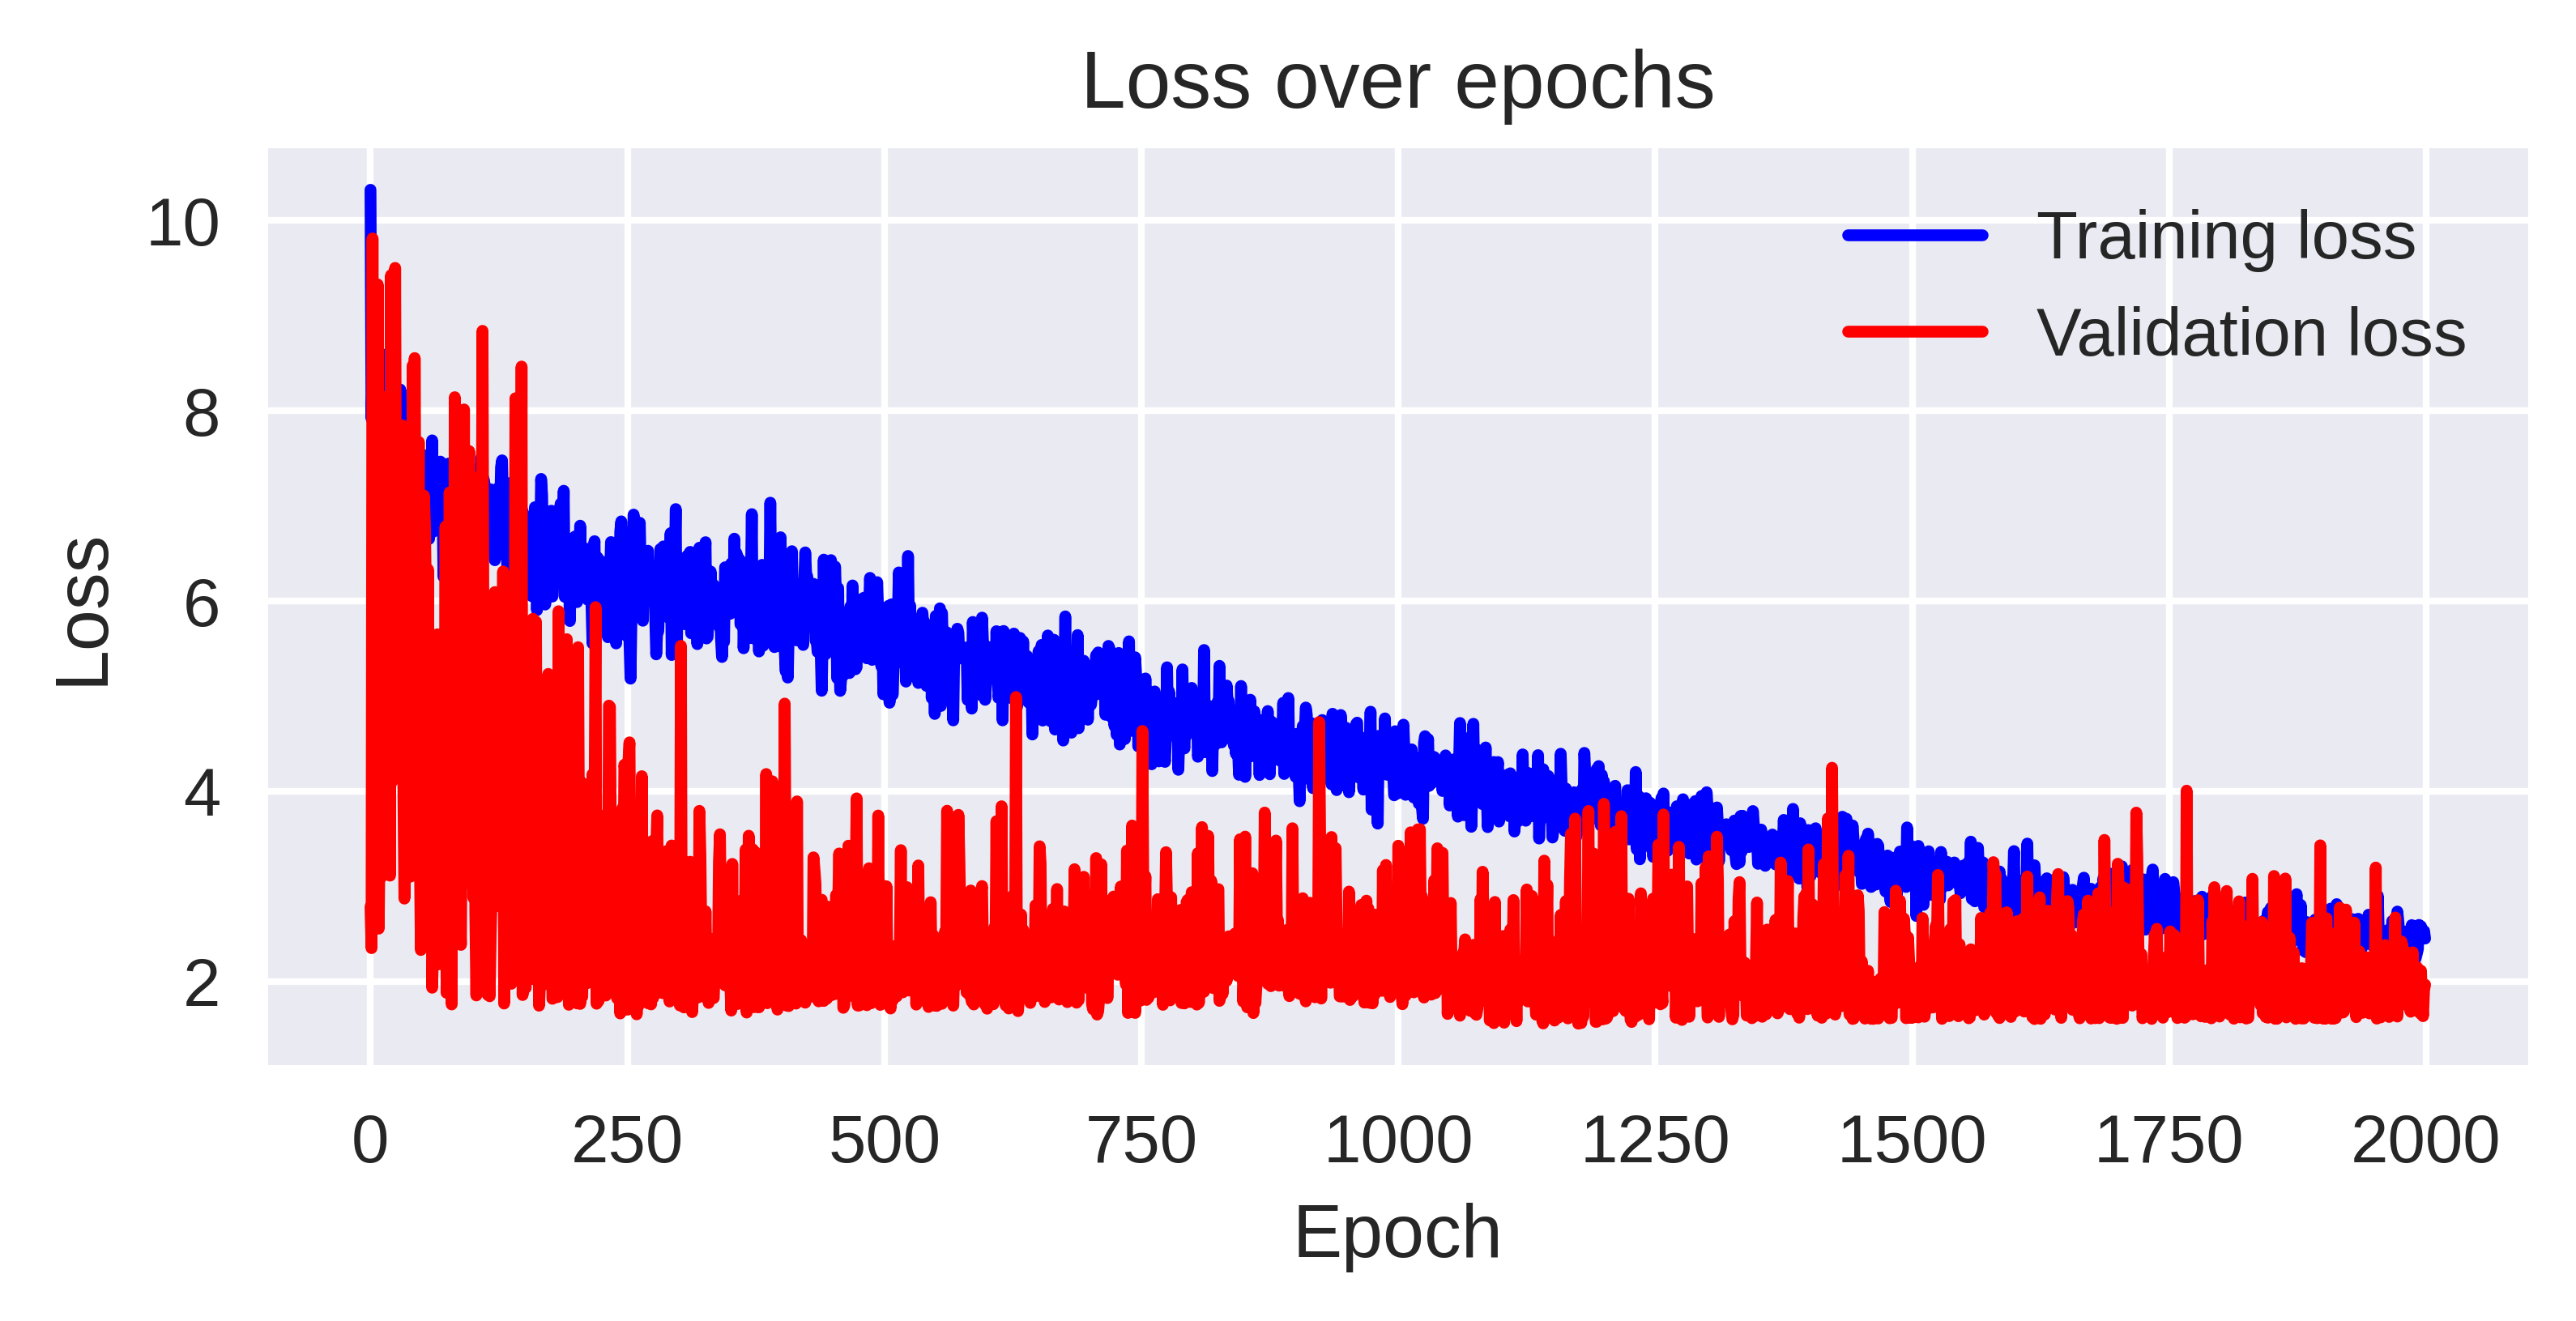

In [80]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
plt.show()

11. Load the best model (with the lowest validation loss):

In [81]:
state_dict = torch.load('cnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

12. Obtain the predictions:

In [83]:
y_pred, y_valid = [], []

with torch.no_grad():

    model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_pred.append(model(x_val))
        y_valid.append(y_val)

y_pred = torch.cat(y_pred).numpy().flatten()
y_valid = torch.cat(y_valid).numpy().flatten()

13. Evaluate the predictions:

CNN's forecast - MSE: 3.15, RMSE: 1.77


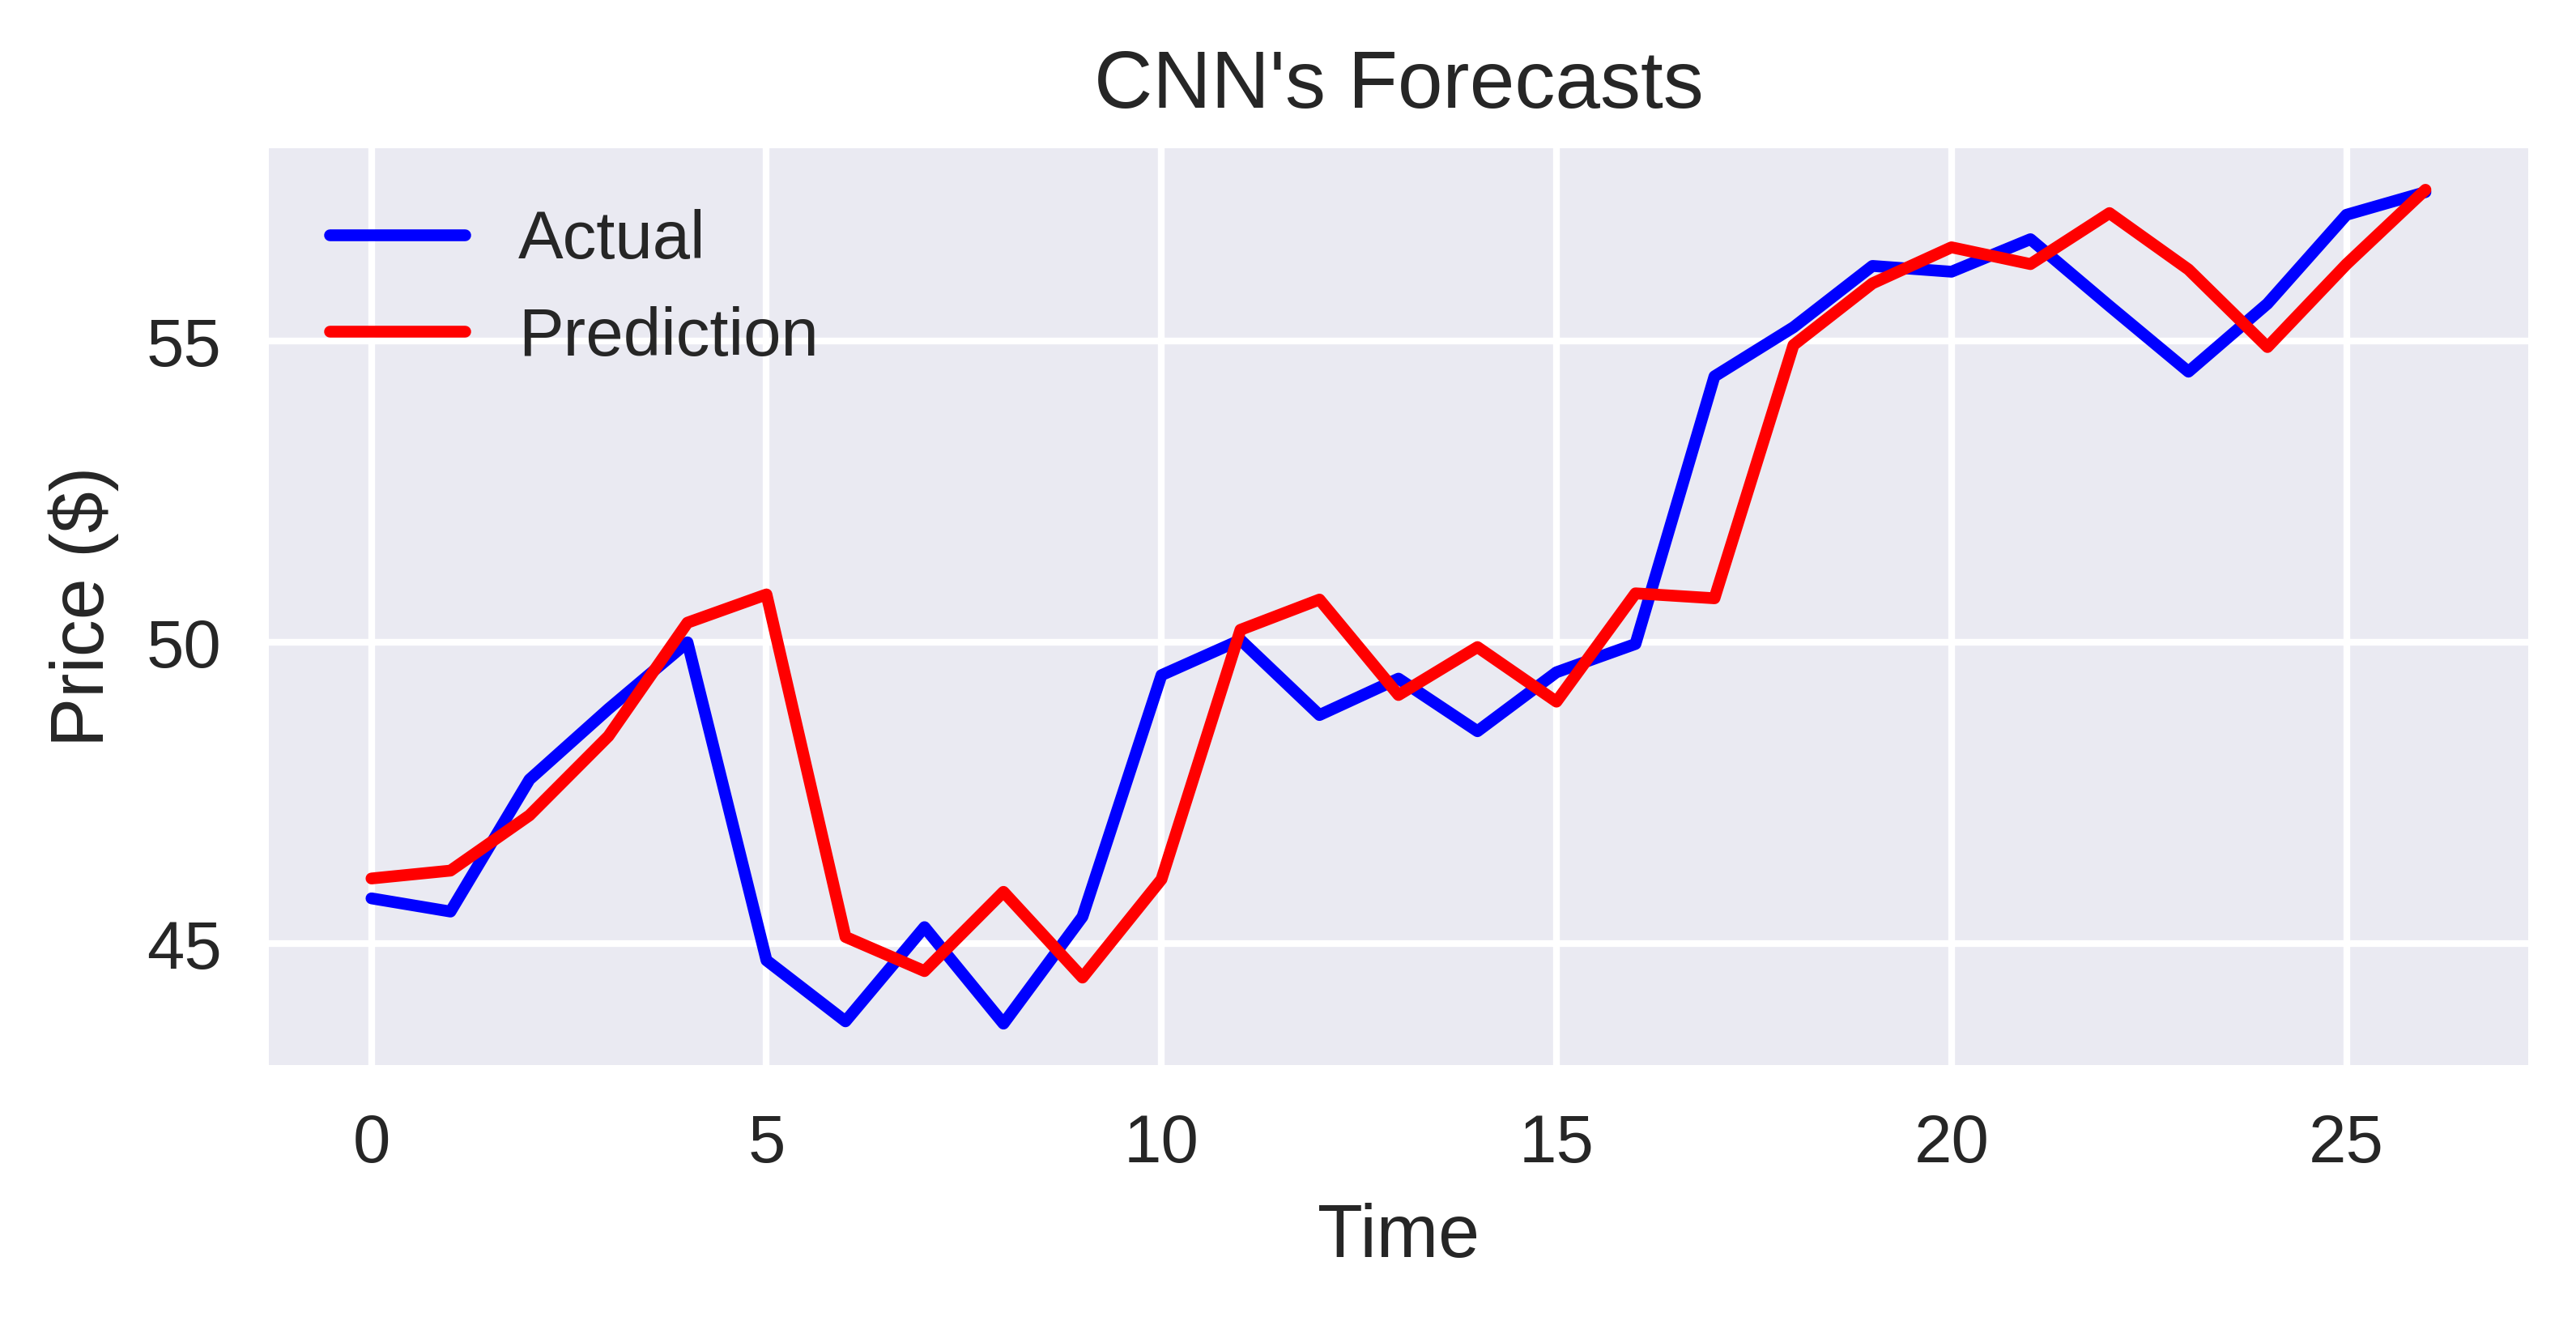

In [84]:
cnn_mse = mean_squared_error(y_valid, y_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"CNN's forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='Prediction')
#ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="CNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()

## Recurrent neural networks for time series forecasting

1. Import the libraries:

In [85]:
import yfinance as yf
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from chapter_10_utils import create_input_data, custom_set_seed

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.9.0+cu102


2. Define the parameters:

In [86]:
# data
TICKER = 'INTC'
START_DATE = '2010-01-02'
END_DATE = '2019-12-31'
VALID_START = '2019-07-01'
N_LAGS = 12

# neural network 
BATCH_SIZE = 16
N_EPOCHS = 100

3. Download and prepare the data:

In [87]:
df = yf.download(TICKER, 
                 start=START_DATE, 
                 end=END_DATE,
                 progress=False)

df = df.resample('W-MON').last()
valid_size = df.loc[VALID_START:END_DATE].shape[0]
prices = df['Adj Close'].values.reshape(-1, 1)

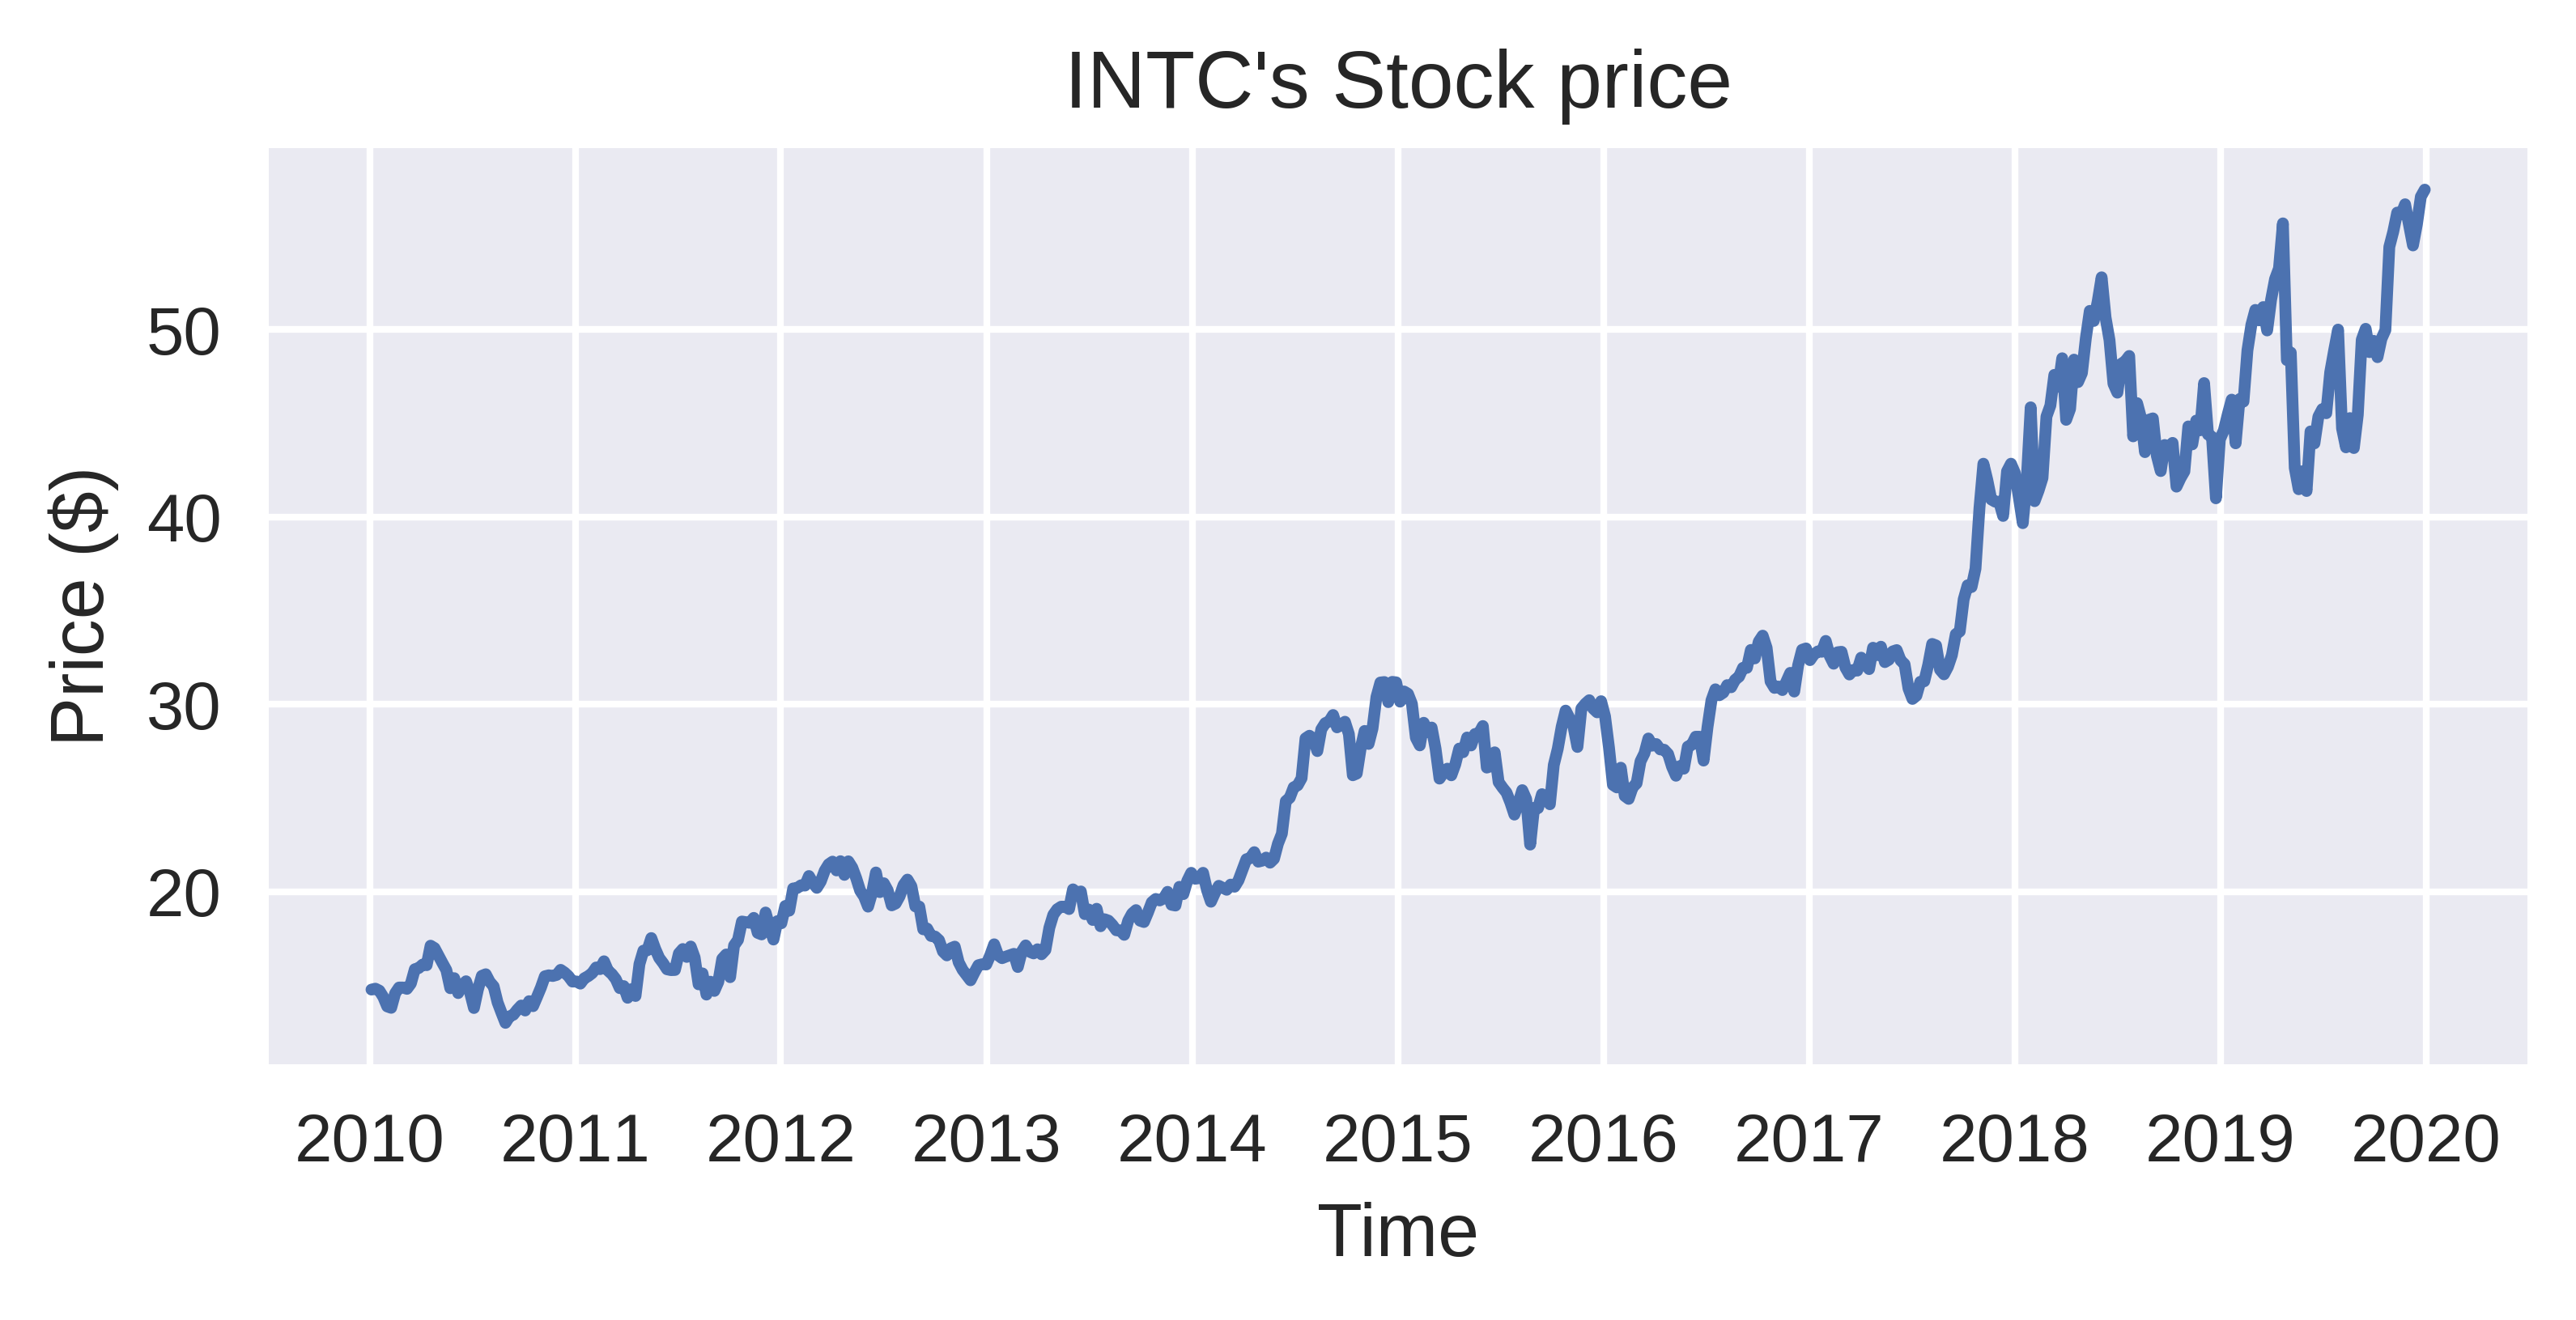

In [88]:
fig, ax = plt.subplots()

ax.plot(df.index, prices)
ax.set(title=f"{TICKER}'s Stock price", 
       xlabel='Time', 
       ylabel='Price ($)');

4. Scale the time series of prices:

In [89]:
valid_ind = len(prices) - valid_size
minmax = MinMaxScaler(feature_range=(0, 1))

prices_train = prices[:valid_ind]
prices_valid = prices[valid_ind:]

minmax.fit(prices_train)

prices_train = minmax.transform(prices_train)
prices_valid = minmax.transform(prices_valid)

prices_scaled = np.concatenate((prices_train, 
                                prices_valid)).flatten()
#plt.plot(prices_scaled)


5. Transform the time series into input for the RNN:

In [90]:
X, y = create_input_data(prices_scaled, N_LAGS)

6. Obtain the naïve forecast:

In [91]:
naive_pred = prices[len(prices)-valid_size-1:-1]
y_valid = prices[len(prices)-valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.4f}, RMSE: {naive_rmse:.4f}")

Naive forecast - MSE: 3.4279, RMSE: 1.8515


7. Prepare the `DataLoader` objects:

In [92]:
# set seed for reproducibility
custom_set_seed(42)

valid_ind = len(X) - valid_size

X_tensor = torch.from_numpy(X).float().reshape(X.shape[0], 
                                               X.shape[1], 
                                               1)
y_tensor = torch.from_numpy(y).float().reshape(X.shape[0], 1)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE)

Check the size of the datasets:

In [93]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 483 | validation: 27


8. Define the model:

In [95]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers, output_size):
      super(RNN, self).__init__()
      self.rnn = nn.RNN(input_size, hidden_size, 
                        n_layers, batch_first=True,
                        nonlinearity='relu')
      self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
      output, _ = self.rnn(x)
      output = self.fc(output[:,-1,:]) 
      return output

9. Instantiate the model, the loss function and the optimizer:

In [96]:
model = RNN(input_size=1, hidden_size=6, 
            n_layers=1, output_size=1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

10. Train the network:

In [99]:
PRINT_EVERY = 10
train_losses, valid_losses = [], []

for epoch in range(N_EPOCHS):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()

    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = torch.sqrt(loss_fn(y_batch, y_hat))
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)

    epoch_loss_train = running_loss_train / len(train_loader)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        model.eval()
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = torch.sqrt(loss_fn(y_val, y_hat))
            running_loss_valid += loss.item() * x_val.size(0)

        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './rnn_checkpoint.pth')

        valid_losses.append(epoch_loss_valid)

        if epoch % PRINT_EVERY == 0:
            print(f"<{epoch}> - Train. loss: {epoch_loss_train:.4f} \t Valid. loss: {epoch_loss_valid:.4f}")

print(f'Lowest loss recorded in epoch: {best_epoch}')



<0> - Train. loss: 4.7753 	 Valid. loss: 0.5823
<10> - Train. loss: 0.5075 	 Valid. loss: 0.0500
<20> - Train. loss: 0.4991 	 Valid. loss: 0.0489
<30> - Train. loss: 0.4435 	 Valid. loss: 0.0473
<40> - Train. loss: 0.4303 	 Valid. loss: 0.0504
<50> - Train. loss: 0.4167 	 Valid. loss: 0.0515
<60> - Train. loss: 0.4029 	 Valid. loss: 0.0485
<70> - Train. loss: 0.3917 	 Valid. loss: 0.0528
<80> - Train. loss: 0.4040 	 Valid. loss: 0.0482
<90> - Train. loss: 0.4374 	 Valid. loss: 0.0451
Lowest loss recorded in epoch: 95


11. Plot the losses over epochs:

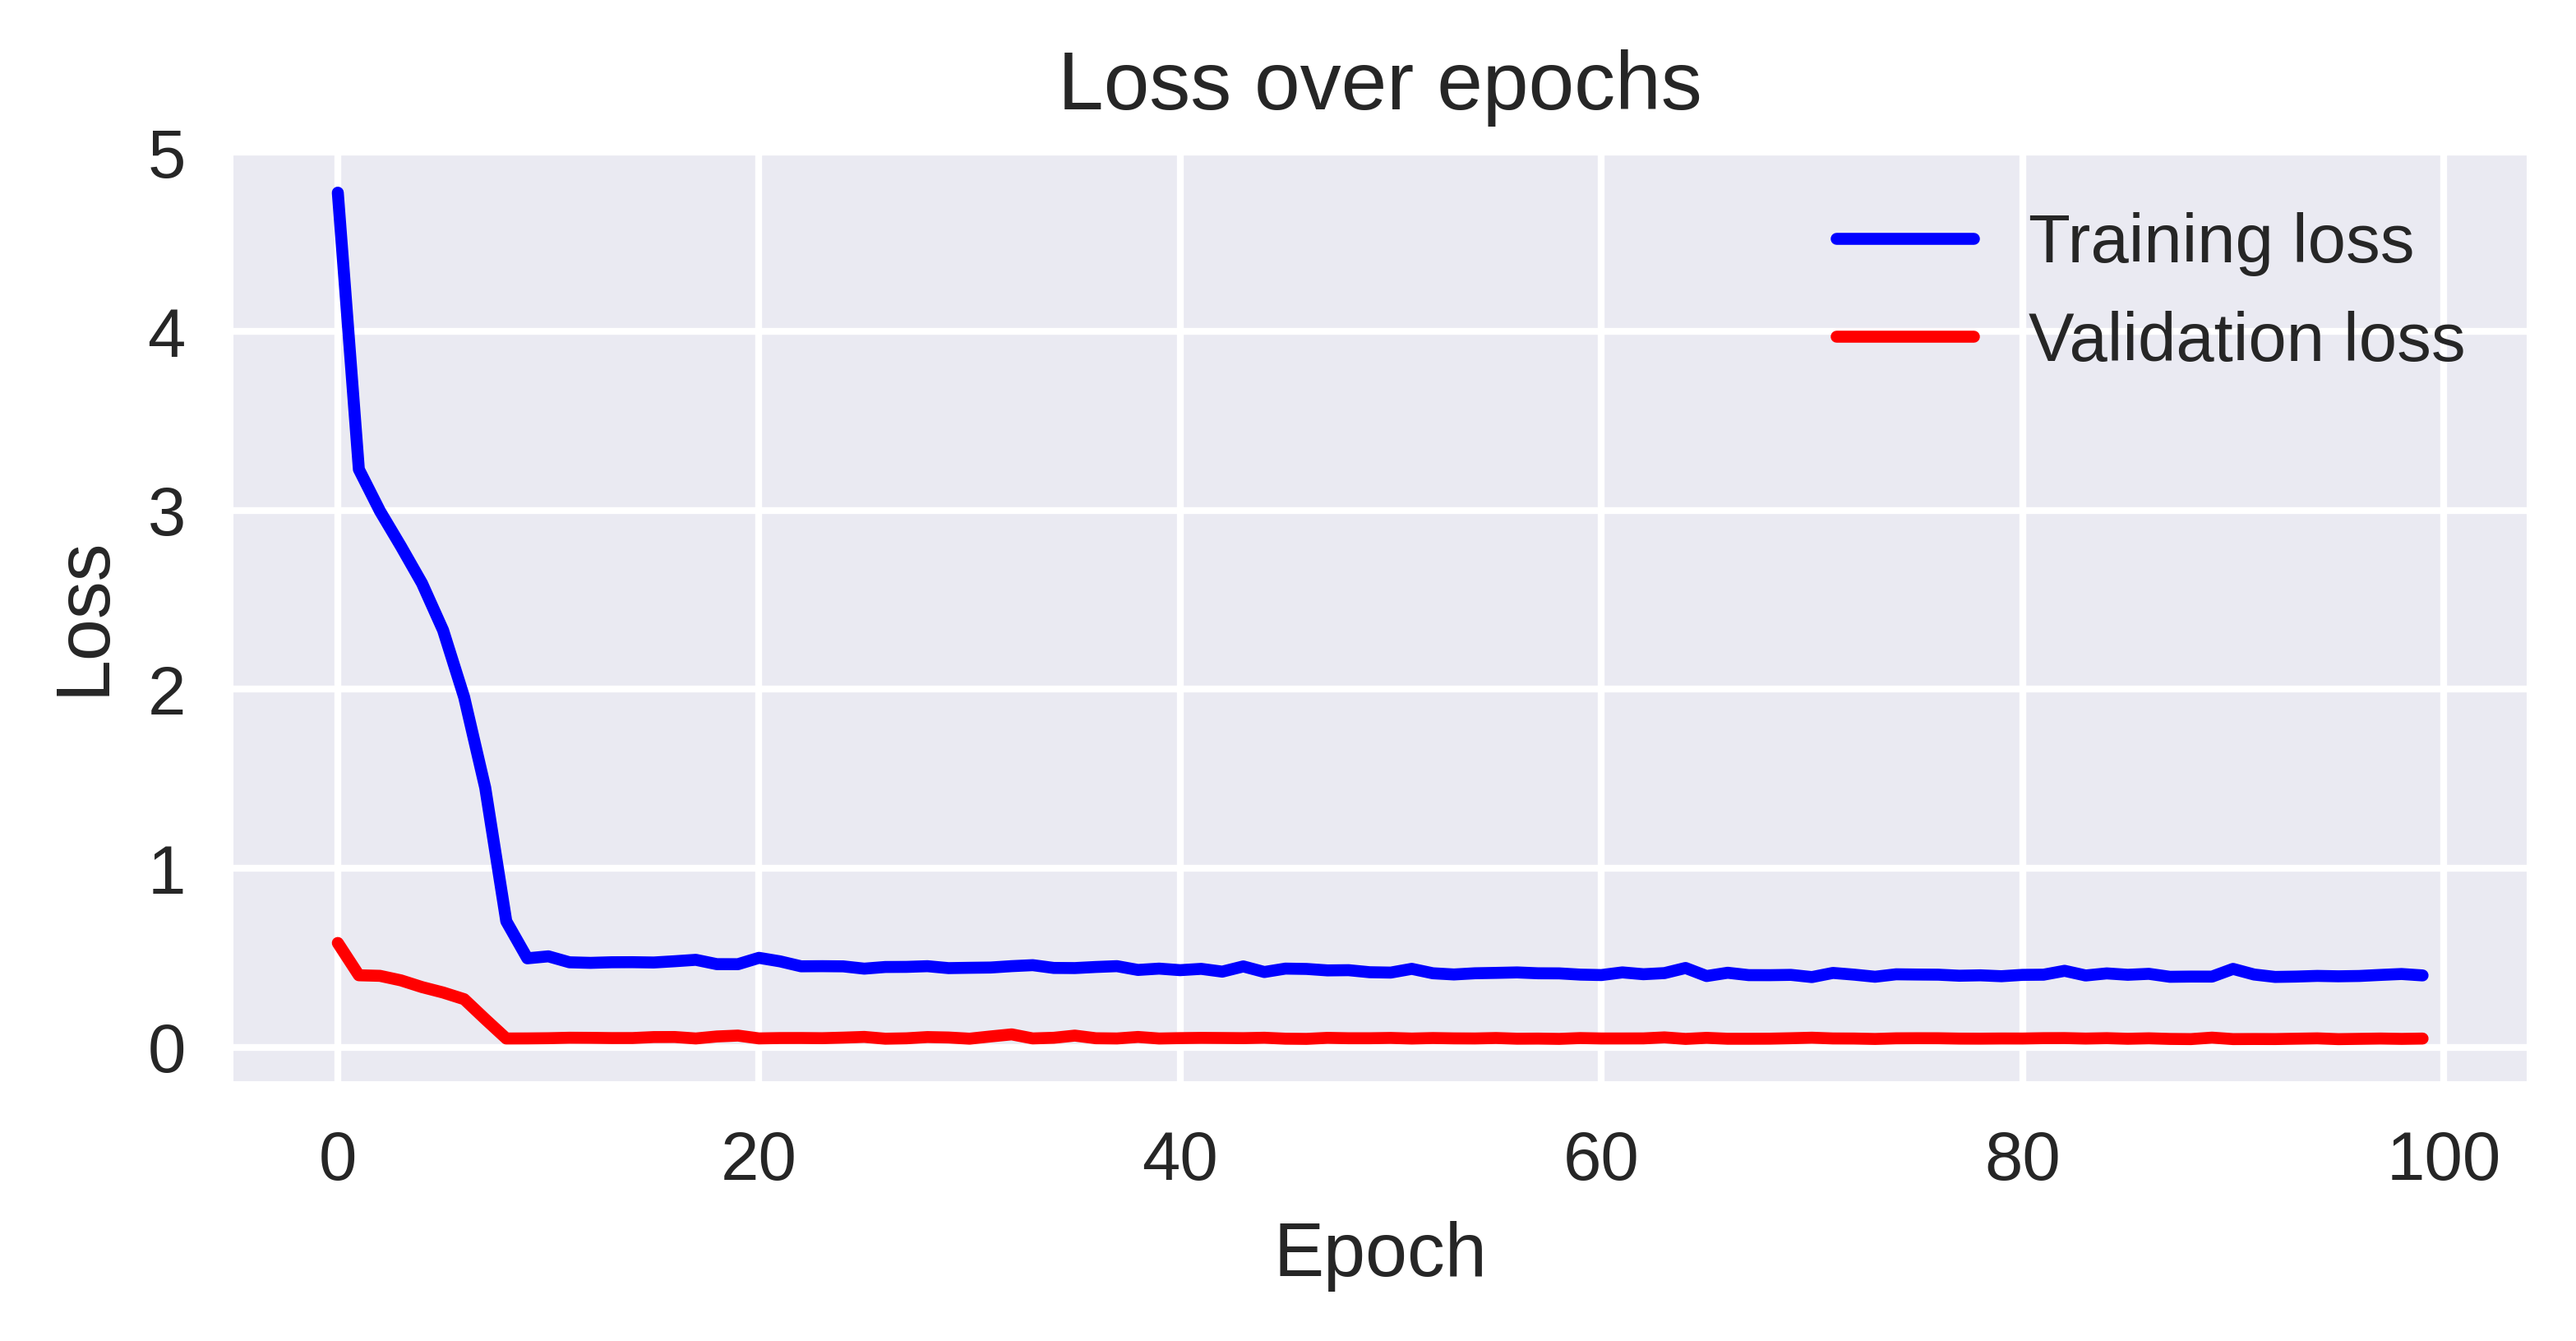

In [100]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs", 
       xlabel='Epoch', 
       ylabel='Loss')
ax.legend()

# plt.tight_layout()
plt.show()

12. Load the best model (with the lowest validation loss):

In [101]:
state_dict = torch.load('rnn_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

13. Obtain the predictions:

In [102]:
y_pred = []

with torch.no_grad():

    model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        y_hat = model(x_val)
        y_pred.append(y_hat)

y_pred = torch.cat(y_pred).numpy()
y_pred = minmax.inverse_transform(y_pred).flatten()

14. Evaluate the predictions:

RNN's forecast - MSE: 3.6961, RMSE: 1.9225


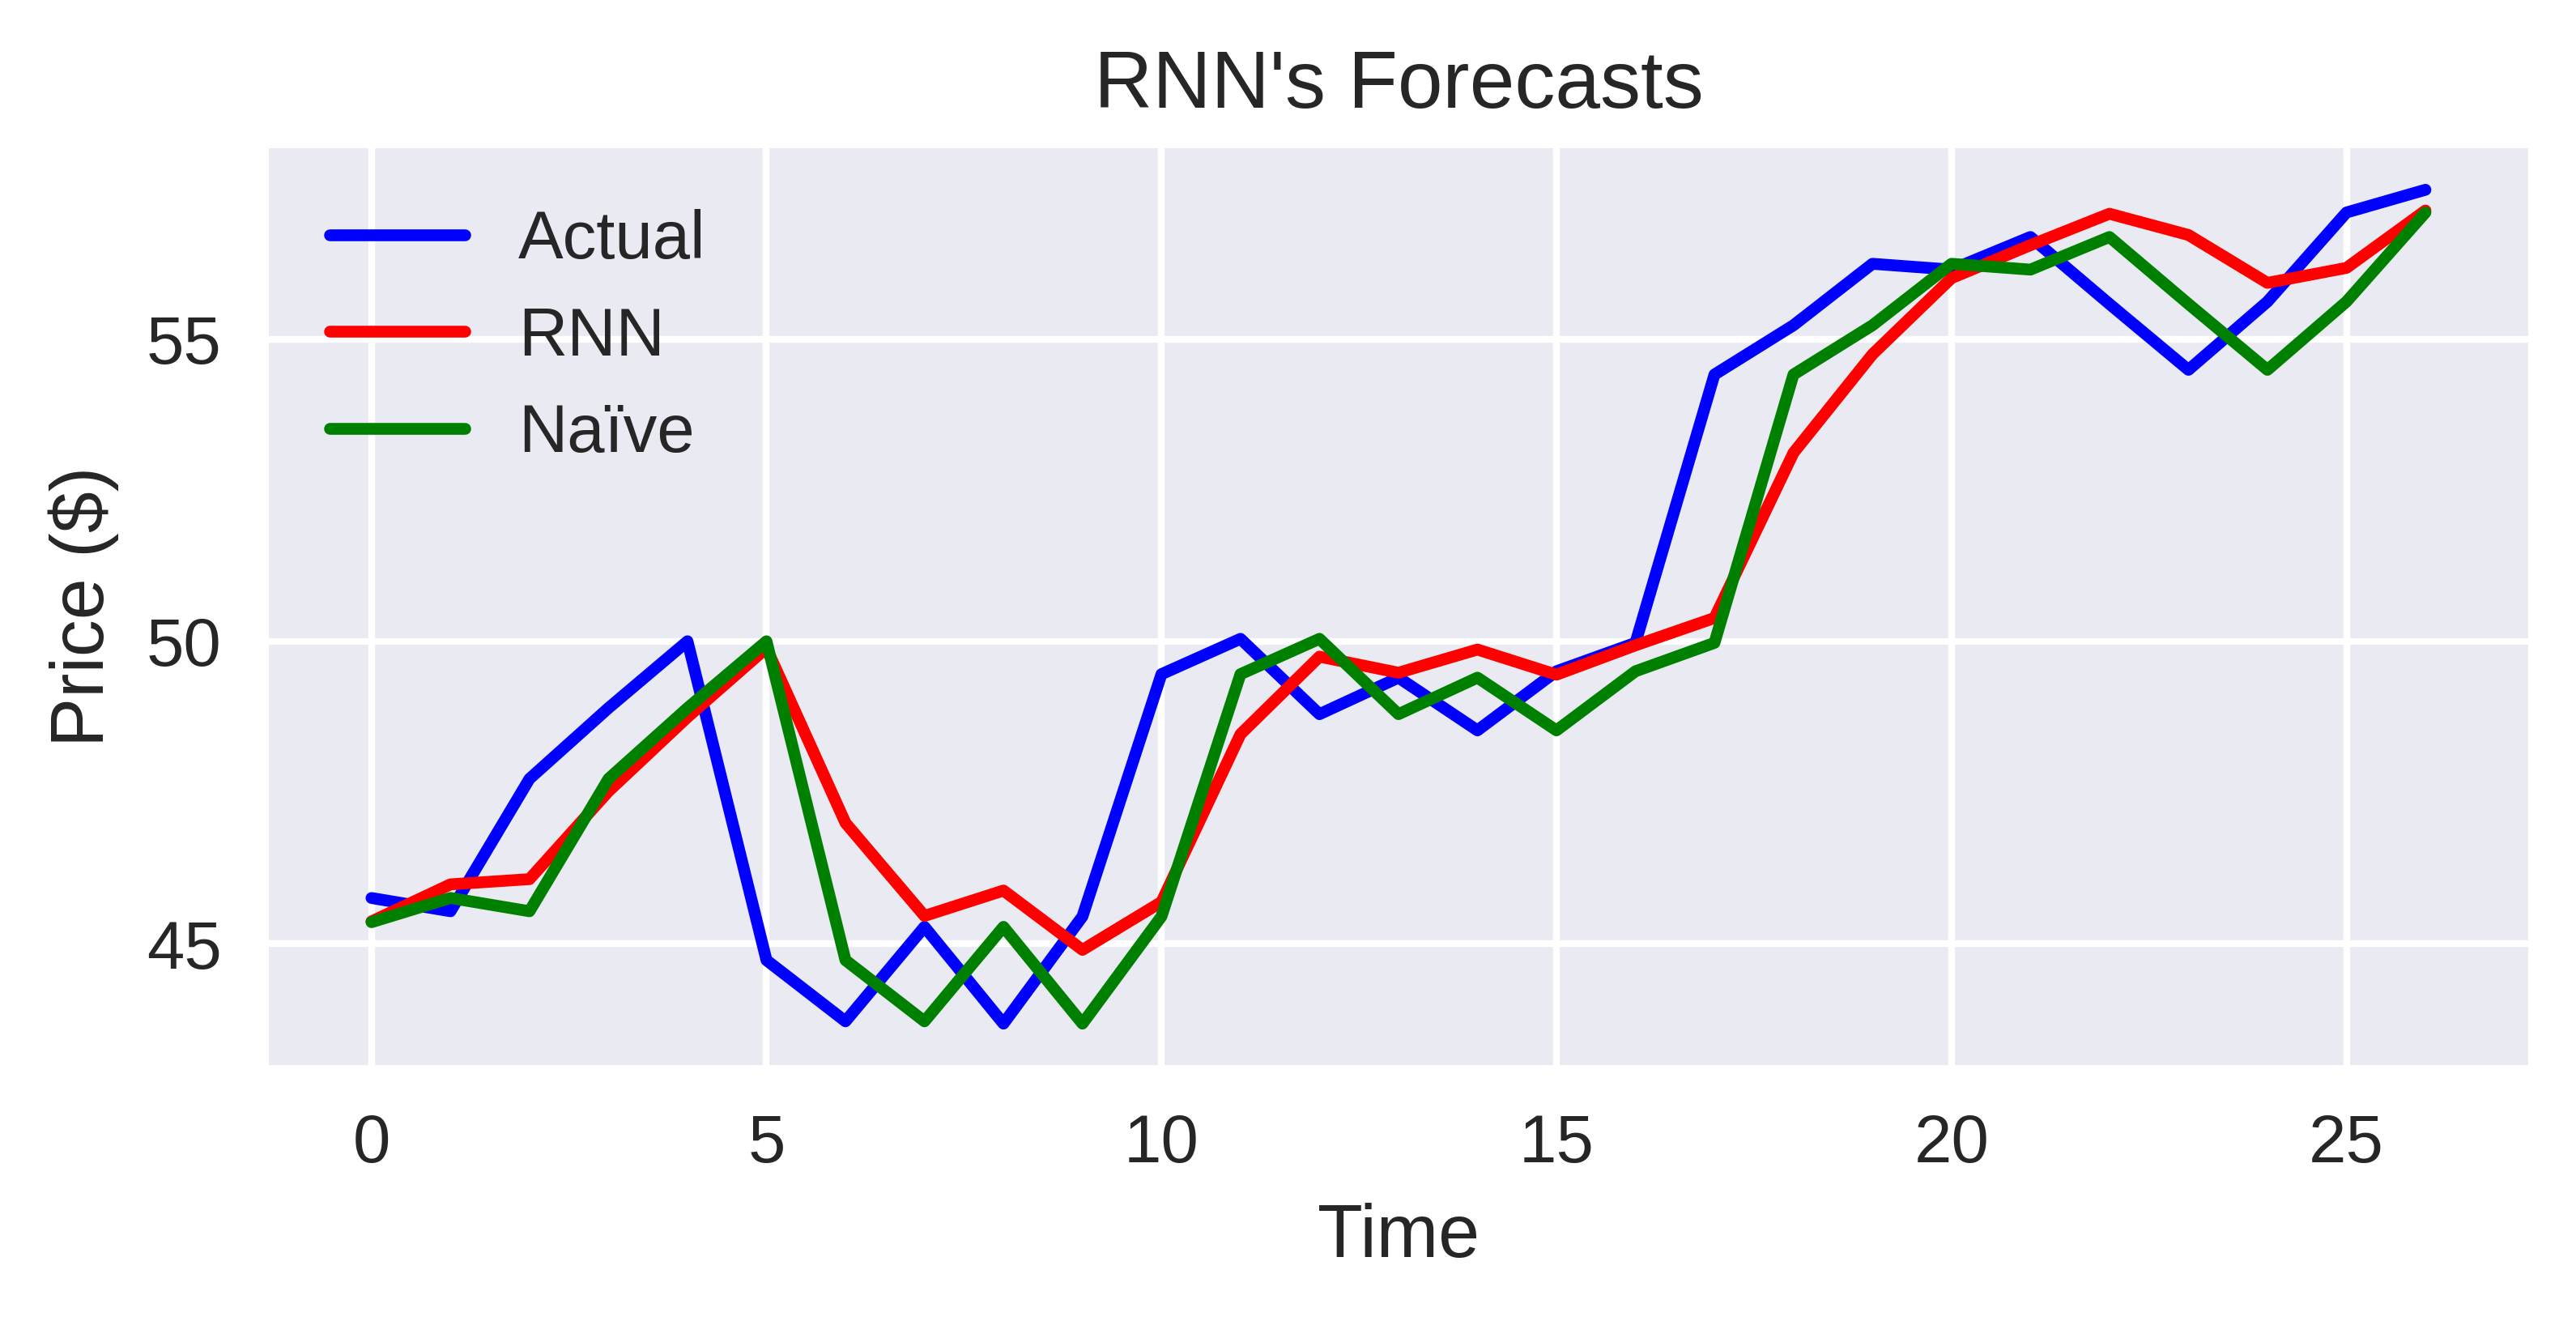

In [103]:
rnn_mse = mean_squared_error(y_valid, y_pred)
rnn_rmse = np.sqrt(rnn_mse)
print(f"RNN's forecast - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}")

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='Actual')
ax.plot(y_pred, color='red', label='RNN')
ax.plot(naive_pred, color='green', label='Naïve')

ax.set(title="RNN's Forecasts", 
       xlabel='Time', 
       ylabel='Price ($)')
ax.legend()

# plt.tight_layout()
plt.show()